In [1]:
# remember to scale problem
# include CoT
# include seeds
# get proper values - length and angles
# plot tau vs speed and Fp vs speed for accuracy


Once deleted, variables cannot be recovered. Proceed (y/[n])? y
Don't know how to reset  #, please run `%reset?` for details
Don't know how to reset  clears, please run `%reset?` for details
Don't know how to reset  variables, please run `%reset?` for details
Flushing input history
Don't know how to reset  workspace, please run `%reset?` for details
--------------
--------------
Stall Torque =  153.4


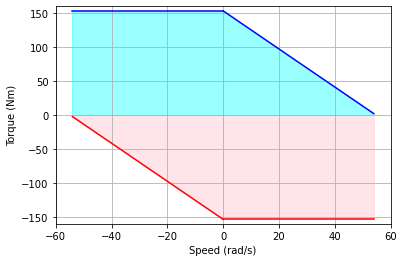

In [2]:
%reset # clears variables in workspace

# import libraries
from pyomo.environ import*
from pyomo.opt import SolverFactory
from pyomo.opt import SolverStatus, TerminationCondition
import sympy as sym
import numpy as np
from IPython.display import display
from sympy import pprint

# import EOM
import dill
dill.load_session('M1_simplified_Aug25.db')

func_map = {'sin':sin, 'cos':cos} 

sym_list = [g] +\
           [masses[link] for link in links] +\
           [lengths[link] for link in links] +\
           [inertias[link] for link in links] +\
           [x_body]+[y_body] + [th[link] for link in links if 'foot' not in link]+[r_prismatic[link] for link in links if 'foot' in link]+\
           [dx_body]+[dy_body] + [dth[link] for link in links if 'foot' not in link]+[dr_prismatic[link] for link in links if 'foot' in link] +\
           [ddx_body]+[ddy_body] + [ddth[link] for link in links if 'foot' not in link]+[ddr_prismatic[link] for link in links if 'foot' in link] +\
           [tau['left']] + [tau['right']] +\
           [fp['left']] + [fp['right']] +\
           [grf['x','left']] + [grf['y','left']] +\
           [grf['x','right']] + [grf['y','right']]

lamb_EOMs = {}

DOFs = ['x_body'] + ['y_body']

for link in links:
    if 'foot' in link:
        DOFs = DOFs + ['{{r_prismatic}}_{{{0}}}'.format(link)]
    else:
        DOFs = DOFs + ['theta_{0}'.format(link)]

for dof_i,dof in enumerate(DOFs):
    lamb_EOMs.update({dof: sym.lambdify(sym_list,EOMs[dof_i],modules = [func_map])})

    
# PARAMETERS:
masses_ = {'body':5670/1000,
           'UL': 867/1000,
           'UR': 867/1000,
           'footL': 180/1000,
           'footR': 180/1000}

lengths_ = {'body': 24/100,
           'UL': 15.0/100,
           'UR': 15.0/100,
           'footL': 4.0/100,
           'footR': 4.0/100}

''' ****** '''
inertias_ = {'body': (masses_['body']*lengths_['body']**2)/12, # body rotate about its center 
            'UL': (masses_['UL']*lengths_['UL']**2)/12, # rotates as pendulumn ?
            'UR': (masses_['UR']*lengths_['UR']**2)/12,
            'footL': 0.0,
            'footR': 0.0}

WDOFs = ['X','Y'] 
signs = ['-ve','+ve'] 
links = ['body','UL','UR','footL','footR']
ground_constraints = ['contact','friction','slip_+ve','slip_-ve'] # Group all constraints occuring at the ground
sides = ['left','right']
feet = ['footL','footR']
coordinates = {'X':0 , 'Y':1}
motor_w_angle = {'left': 'UL' ,'right': 'UR'}


total_mass = 0.0
for mass in masses_:
    total_mass += masses_[mass]
total_mass

def get_var_list_zeros(m,n):
    var_list = [m.g] +\
               [m.masses[link] for link in links] +\
               [m.lengths[link] for link in links] +\
               [m.inertias[link] for link in links] +\
               [m.q[n,dof] for dof in DOFs] +\
               [m.dq[n,dof] for dof in DOFs] +\
               [m.ddq[n,dof] for dof in DOFs] +\
               [0.0] + [0.0] +\
               [0.0] + [0.0] +\
               [0.0] + [0.0] +\
               [0.0] + [0.0]
    return var_list

def get_var_list_values(m,n):
    
    BW = 1
    tau_value = {}
    prismatic_force_value = {}
    GRF_X_value = {}
    GRF_Y_value = {}
        
    for side in sides:
                
        tau_value.update({(side): \
        BW*(m.tau_torque[n,side])})
    
        prismatic_force_value.update({(side):\
        BW*(m.Fp[n,side])})
        
    for foot in feet:
        GRF_X_value.update({(foot):BW*(m.GRF_x[n,'+ve',foot]-m.GRF_x[n,'-ve',foot])})
        GRF_Y_value.update({(foot):BW*(m.GRF_y[n,foot])})
    
    var_list = [m.g] +\
               [m.masses[link] for link in links] +\
               [m.lengths[link] for link in links] +\
               [m.inertias[link] for link in links] +\
               [m.q[n,dof] for dof in DOFs] +\
               [m.dq[n,dof] for dof in DOFs] +\
               [m.ddq[n,dof] for dof in DOFs] +\
               [tau_value['left']] + [tau_value['right']] +\
               [prismatic_force_value['left']] + [prismatic_force_value['right']] +\
               [GRF_X_value['footL']] + [GRF_Y_value['footL']] +\
               [GRF_X_value['footR']] + [GRF_Y_value['footR']]
    return var_list

'''Plot Torque Speed Curve'''
import matplotlib.pyplot as plt
x_p = np.linspace(0, 54, num=54)
x_n = np.linspace(-54, 0, num=54)
y_p = -2.8*x_p + 153.4
y_n = -2.8*x_n - 153.4

stall_torque = 153.4
max_torque_p = []
max_torque_n = []

for ii in range(len(x_p)):
    max_torque_p.append(stall_torque)
    max_torque_n.append(-stall_torque)

plt.grid()
plt.plot(x_p, y_p,'b')
plt.plot(x_n, max_torque_p,'b')

plt.fill_between(x_p, y_p, alpha=0.4, color = 'cyan')
plt.fill_between(x_n, max_torque_p, alpha=0.4,color = 'cyan')

plt.plot(x_n, y_n,'r')
plt.plot(x_p, max_torque_n,'r')

plt.fill_between(x_n, y_n, alpha=0.4,color = 'pink')
plt.fill_between(x_p, max_torque_n, alpha=0.4,color = 'pink')

plt.axis((-60,60,-160,160))
plt.xlabel('Speed (rad/s)')
plt.ylabel('Torque (Nm)')
print('--------------')

Stall_torque = 153.4 #Nm
No_load_speed = 54.8 #rad/s

print('--------------')
print('Stall Torque = ', 153.4)

<a href='#initial_conditions'>Link to initial conditions'</a>

<a href='#time_step'>Link to time step'</a>

<a href='#cost_function'>Link to cost function'</a>

<a href='#constraints'>Link to constraints'</a>

<a id='time_step'></a>

In [3]:
tests = {0:"High_Drop_Test",1:"Low_Drop_Test", 2:"Hop_Test", 3:"Drop_Hop_Test",\
         4:"Standing_Test", 5:"Tax_Day_Sprint",6:"Missing_the_Boat",\
         7:"Periodic_Hop",8:"Periodic_Run",9:"Stop_Periodic_Run"}

test = tests[9]
V_avg = 9.0
if test == "High_Drop_Test" or test == "Low_Drop_Test" or test == "Standing_Test":
    N = 50
    TT = 0.3
elif test == "Hop_Test" or test == "Drop_Hop_Test":
    N = 50
    TT = 1.0
elif test == "Tax_Day_Sprint":
    N = 50
    TT = 1.5
    x_final = 5.0
elif test == "Missing_the_Boat":
    N = 50
    TT = 1.0
    x_final = 5.0
elif test == "Periodic_Hop":
    N = 50
    TT = 1.0 # 2Hz but only half a gait due to symmetry
    dy_periodic = 0.5
elif test == "Periodic_Run":
    N = 50
    TT = 0.3 # 2Hz but only half a gait due to symmetry
    V_flight = 0.75*sqrt(9.81*(0.18+0.35)) # from paper
    x_final = 3.0 # for display
elif test == "Stop_Periodic_Run":
    N = 100
    TT = 1.0 # 2Hz but only half a gait due to symmetry
    x_final = 5.0 # for display 
    
    import csv
    file = open(str(round(V_avg))+'.csv')
    csvreader = csv.reader(file)
    rows = []
    for row in csvreader:
        rows.append(row)
    initial_conditions = {}
    for item in rows:
        initial_conditions[item[0]] = float(item[1])
else:
    N = 50
    TT = 0.5
    

In [4]:
print("total mass = " ,total_mass)
print("test = ",test)

total mass =  7.763999999999999
test =  Stop_Periodic_Run


In [5]:
m = ConcreteModel('Biped')

#SETS-------------------------
m.N = RangeSet(N)
m.ground_constraints = Set(initialize = ground_constraints)
m.links = Set(initialize = links)
m.DOFs = Set(initialize = DOFs)
m.WDOFs = Set(initialize = WDOFs)
m.signs = Set(initialize = signs)
m.sides = Set(initialize = sides)
m.feet = Set(initialize = feet)


#Params--------------------------
m.g = Param(initialize = 9.81)

# m.masses = Param(m.links, initialize = masses)
m.masses = Param(m.links, initialize = masses_)
m.lengths = Param(m.links, initialize = lengths_)
m.inertias = Param(m.links, initialize = inertias_)


#VARIABLES----------------------
#gen coordinates
m.q = Var(m.N,m.DOFs)
m.dq = Var(m.N,m.DOFs)
m.ddq = Var(m.N,m.DOFs)

In [6]:
''' CONSTRAINTS  - Integration'''

# variable timestep
hm = TT/N # master timestep
m.h = Var(m.N, bounds = (0.8,1.2))

def BwEuler_p(m,n,dof):
    if n > 1:
        return m.q[n,dof] == m.q[n-1,dof] + hm*m.h[n]*m.dq[n,dof]
    else:
        return Constraint.Skip
m.integrate_p = Constraint(m.N, m.DOFs, rule = BwEuler_p)

def BwEuler_v(m,n,dof):
    if n > 1:
        return m.dq[n,dof] == m.dq[n-1,dof] + hm*m.h[n]*m.ddq[n,dof]
    else:
        return Constraint.Skip 
m.integrate_v = Constraint(m.N, m.DOFs, rule = BwEuler_v)

In [7]:
#Variable of foot position
m.foot_position = Var(m.N, m.WDOFs, m.feet)
for n in range(1,N+1):
    m.foot_position[n,'Y','footL'].setlb(0.0)
    m.foot_position[n,'Y','footR'].setlb(0.0)

#Get the foot position in WDOF
lamb_foot_position = {}
[lamb_foot_position.update({(wdof,foot): sym.lambdify(sym_list,r_links[foot][coordinates[wdof]],modules = [func_map])}) for foot in feet for wdof in WDOFs]

def def_foot_position(m,n,wdof,foot):
    var_list = get_var_list_zeros(m,n)
    return m.foot_position[n,wdof,foot] == lamb_foot_position[wdof,foot](*var_list)
m.def_foot_position = Constraint(m.N, m.WDOFs, m.feet, rule = def_foot_position)

m.mu = Param(initialize = 10.0,within=Any)

# Variables
m.foot_velocity = Var(m.N, m.WDOFs, m.signs, m.feet, bounds = (0.0,None)) # the sign will account for -ve velocities
m.friction_cone = Var(m.N, m.feet, bounds = (0.0,None)) 
m.GRF_y = Var(m.N, m.feet, bounds = (0.0,10*total_mass*m.g.value)) # ground reaction forces
m.GRF_x = Var(m.N, m.signs, m.feet, bounds = (0.0,10*total_mass*m.g.value)) # ground reaction forces

'''******'''
m.ground_penalty = Var(m.N, m.ground_constraints, m.feet, bounds = (0.0,10.0)) # penalty

lamb_foot_velocity_x = {}

# Get the foot position in WDOF
[lamb_foot_velocity_x.update({(foot): sym.lambdify(sym_list,(r_links[foot].jacobian(q)*dq)[0].simplify(),modules = [func_map])}) for foot in feet]

# CONSTRAINTS
def def_foot_velocity(m,n,wdof,foot):
    if wdof == 'X':
        var_list = get_var_list_zeros(m,n)
        return m.foot_velocity[n,'X','+ve',foot]-m.foot_velocity[n,'X','-ve',foot] == lamb_foot_velocity_x[foot](*var_list)
    else: return Constraint.Skip
m.foot_velocity_constraint = Constraint(m.N, m.WDOFs, m.feet, rule = def_foot_velocity)

def def_friction_cone(m,n,foot):
    return m.friction_cone[n,foot] == m.mu*m.GRF_y[n,foot] - (m.GRF_x[n,'+ve',foot] + m.GRF_x[n,'-ve',foot])
m.friction_cone_constraint = Constraint(m.N, m.feet, rule = def_friction_cone)

# constraints: complementarity

# contact
def def_ground_contact(m,n,foot):
    if n < N:
        return m.foot_position[n+1,'Y',foot]*m.GRF_y[n,foot] <= m.ground_penalty[n,'contact',foot]
    else:
        return Constraint.Skip
m.ground_contact_constraint = Constraint(m.N, m.feet, rule = def_ground_contact)

# friction
def def_ground_friction(m,n,foot):
    return (m.foot_velocity[n,'X','+ve',foot]+m.foot_velocity[n,'X','-ve',foot])*m.friction_cone[n,foot] <= m.ground_penalty[n,'friction',foot]
m.ground_friction_constraint = Constraint(m.N, m.feet, rule = def_ground_friction)

# slipping
def def_ground_slip_positive(m,n,foot):
    return m.foot_velocity[n,'X','+ve',foot]*m.GRF_x[n,'+ve',foot] <= m.ground_penalty[n,'slip_+ve',foot]
m.ground_slip_positive_constraint = Constraint(m.N, m.feet, rule = def_ground_slip_positive)

def def_ground_slip_negative(m,n,foot):
    return m.foot_velocity[n,'X','-ve',foot]*m.GRF_x[n,'-ve',foot] <= m.ground_penalty[n,'slip_-ve',foot]
m.ground_slip_negative_constraint = Constraint(m.N, m.feet, rule = def_ground_slip_negative)

# bound contact forces at last node
for foot in feet:
    m.GRF_y[N,foot].fix(0.0)
    for sgn in signs:
        m.GRF_x[N,sgn,foot].fix(0.0)

In [8]:
'''Torque Speed - Speed Torque Curve'''

max_torque = 38.0
max_rotational_speed = 46.0

m.tau_torque = Var(m.N, m.sides,bounds = (-max_torque,max_torque))
m.tau_velocity = Var(m.N, m.sides,bounds = (-max_rotational_speed,max_rotational_speed))

lamb_tau_velocity = {}
[lamb_tau_velocity.update({(side): sym.lambdify(sym_list,dr_links[motor_w_angle[side]][2],modules = [func_map])}) for side in sides]

def def_angular_velocity(m,n,side):
    var_list = get_var_list_zeros(m,n)
    return m.tau_velocity[n,side] == lamb_tau_velocity[side](*var_list)
m.left_angular_velocity_constraint = Constraint(m.N, m.sides,rule = def_angular_velocity)

# assume straight line
def def_constant_power_right(m,n,side):
    return m.tau_torque[n,side] <= m.tau_velocity[n,side]*(-2.8) + 153.4
m.constant_power_right_constraint = Constraint(m.N, m.sides,rule = def_constant_power_right)

def def_constant_power_left(m,n,side):
    return m.tau_torque[n,side] >= m.tau_velocity[n,side]*(-2.8) - 153.4
m.constant_power_left_constraint = Constraint(m.N, m.sides,rule = def_constant_power_left)

In [9]:
# m.Fp = Var(m.N, m.sides, bounds = (-total_mass*9.81,total_mass*9.81))

# Fo = 5*(total_mass*9.81) = 383N

# given the torque speed curve, what radius should the pinion be such that Fo = 383N?
Tau_stall = 153.4 # using the equation: y_p = -2.8*x_p + 153.4
pinion_radius = 0.4 # T = F*d
Fo = Tau_stall/pinion_radius # stall force
# max_power = max_torque*max_rotational_speed # Tau_max*w_max    https://www.clear.rice.edu/elec201/Book/motors.html 
max_power = (153.4*54.8)/4
Fp_max = max_torque/pinion_radius
m.Fp = Var(m.N, m.sides,bounds = (-Fp_max,Fp_max))


max_translational_speed = max_rotational_speed*pinion_radius 
m.Fp_velocity = Var(m.N, m.sides,bounds = (-max_translational_speed,max_translational_speed))


lamb_Fp_velocity = {}
lamb_Fp_velocity.update({('left'): sym.lambdify(sym_list,dq[5],modules = [func_map])})
lamb_Fp_velocity.update({('right'): sym.lambdify(sym_list,dq[6],modules = [func_map])})


def def_Fp_velocity(m,n,side):
    var_list = get_var_list_zeros(m,n)
    return m.Fp_velocity[n,side] == lamb_Fp_velocity[side](*var_list)   
m.Fp_velocity_constraint = Constraint(m.N, m.sides, rule = def_Fp_velocity)

# assume straight line
def def_Fp_right(m,n,side):
    return m.Fp[n,side] <= Fo*(1-((Fo/(4*max_power))*m.Fp_velocity[n,side]))
m.Fp_right_constraint = Constraint(m.N, m.sides,rule = def_Fp_right)

def def_Fp_left(m,n,side):
    return m.Fp[n,side] >= Fo*(-1-((Fo/(4*max_power))*m.Fp_velocity[n,side]))
m.Fp_left_constraint = Constraint(m.N, m.sides,rule = def_Fp_left)

<a id='constraints'></a>

In [10]:
# Get the foot position in WDOF
if test == "Periodic_Run" or test == "Periodic_Hop":
    
    lamb_body_position_x = sym.lambdify(sym_list,(r_links['body'])[0].simplify(),modules = [func_map])
    m.body_position = Var(m.N, m.WDOFs) # the sign will account for -ve velocities

    # CONSTRAINTS
    def def_body_position(m,n,wdof):
        var_list = get_var_list_zeros(m,n)
        
        if wdof == 'X':
            return m.body_position[n,'X'] == lamb_body_position_x(*var_list)
        else: return Constraint.Skip
    m.body_position_constraint = Constraint(m.N, m.WDOFs, rule = def_body_position)
    
    
    if test == "Periodic_Run":
        
        # Average velocities
        def def_body_position_average(m,wdof):
            if wdof == 'X':
                return (m.body_position[N,'X'] - m.body_position[1,'X'])/(sum(hm*m.h[n] for n in range(1,N+1))) == V_avg
            else: return Constraint.Skip
        m.def_body_position_average_constraint = Constraint(m.WDOFs, rule = def_body_position_average)
        
        # Equate states
        def def_equate_position_states(m,n,dof_i):
            if dof_i == 'y_body' or dof_i == 'theta_body':
                return m.q[1,dof_i] == m.q[N,dof_i]
            elif dof_i == '{r_prismatic}_{footL}':
                return m.q[1,'{r_prismatic}_{footL}'] == m.q[N,'{r_prismatic}_{footR}']
            elif dof_i == '{r_prismatic}_{footR}':
                return m.q[1,'{r_prismatic}_{footR}'] == m.q[N,'{r_prismatic}_{footL}']
            elif dof_i == 'theta_UL':
                return m.q[1,'theta_UL'] == m.q[N,'theta_UR']
            elif dof_i == 'theta_UR':
                return m.q[1,'theta_UR'] == m.q[N,'theta_UL']
            else: 
                 return Constraint.Skip
        m.def_equate_position_states_constraint = Constraint(m.N, m.DOFs,rule = def_equate_position_states) 

        
        def def_equate_vel_states(m,n,dof_i):
            return m.dq[1,dof_i] == m.dq[N,dof_i]
        m.def_equate_vel_states_constraint = Constraint(m.N, m.DOFs,rule = def_equate_vel_states)
  
    
        # Condition where the GRF can't increase twice from zero          
    
    
    else: 
        
        def def_equate_position_states(m,n,dof_i):
            return m.q[1,dof_i] == m.q[N,dof_i]
        m.def_equate_position_states_constraint = Constraint(m.N, m.DOFs,rule = def_equate_position_states)
        
        def def_equate_vel_states(m,n,dof_i):
            return m.dq[1,dof_i] == m.dq[N,dof_i]
        m.def_equate_vel_states_constraint = Constraint(m.N, m.DOFs,rule = def_equate_vel_states)

else: pass
                                    


In [11]:
''' Use this code for tests '''

# BOUND VALUES
for n in range(1,N+1):
    m.q[n,'theta_body'].setub(np.pi*(1/4))
    m.q[n,'theta_body'].setlb(np.pi*(-1/4))
    
    # 0.15 - 0.5 = 0.35
    
    m.q[n,'{r_prismatic}_{footL}'].setlb(0.0)
    m.q[n,'{r_prismatic}_{footL}'].setub(0.35)
    m.q[n,'{r_prismatic}_{footR}'].setlb(0.0)
    m.q[n,'{r_prismatic}_{footR}'].setub(0.35)
    
    m.q[n,'theta_UL'].setlb(np.pi*(-1/3))
    m.q[n,'theta_UL'].setub(np.pi*(1/3))
    m.q[n,'theta_UR'].setlb(np.pi*(-1/3))
    m.q[n,'theta_UR'].setub(np.pi*(1/3))
        
    if test == "Periodic_Run":
        m.q[n,'y_body'].setub(1.0)
        m.dq[1,'y_body'].fix(0.0)
        
#         m.dq[1,'theta_UL'].fix(0.0)
#         m.dq[1,'theta_UR'].fix(0.0)
        
    elif test == "Periodic_Hop":
        m.dq[1,'y_body'].fix(0.0)
    
    else:
        for dof in DOFs:
            m.dq[1,dof].fix(0.0)
    
    if test == "High_Drop_Test" or test == "Low_Drop_Test" or test == "Standing_Test" or test == "Drop_Hop_Test" or test =="Periodic_Hop":

        # Set graph limits 
        x_low_lim = -1.0
        x_high_lim = 1.0
        y_low_lim = -0.5
        y_high_lim = 2.0
        
        
        if test == "Drop_Hop_Test" or "Periodic_Hop":
            [m.tau_torque[1,side].fix(0.0) for side in sides]
            [m.Fp[1,side].fix(0.0) for side in sides]
            
        else:
            [m.tau_torque[n,side].fix(0.0) for side in sides]
            [m.Fp[n,side].fix(0.0) for side in sides]
    else:
        # Set graph limits 
        x_low_lim = -1.0
        x_high_lim = x_final + 1.0
        y_low_lim = -0.5
        y_high_lim = 1.5
    
        if test == "Periodic_Run":
            pass
        else:
            [m.tau_torque[1,side].fix(0.0) for side in sides]
            [m.Fp[1,side].fix(0.0) for side in sides]

<a id='initial_conditions'></a>

In [12]:
if test == "High_Drop_Test":
    #  ----------------------------- HIGH DROP TEST ---------------------------

    # initial condition
    m.q[1,'x_body'].fix(0.3)
    m.q[1,'y_body'].fix(1.3)
    m.q[1,'theta_body'].fix(np.pi*(0.0))
    m.q[1,'{r_prismatic}_{footL}'].fix(0.1)
    m.q[1,'{r_prismatic}_{footR}'].fix(0.1)
    m.q[1,'theta_UL'].fix(np.pi*(-2/9))
    m.q[1,'theta_UR'].fix(np.pi*(2/9))
        
elif test == "Low_Drop_Test":
    #  ----------------------------- LOW DROP TEST ---------------------------

    # initial condition
    m.q[1,'x_body'].fix(0.5)
    m.q[1,'theta_body'].fix(np.pi*(0.0))
    m.q[1,'theta_UL'].fix(np.pi*(1/6))
    m.q[1,'theta_UR'].fix(np.pi*(-1/6))
    m.q[1,'{r_prismatic}_{footL}'].fix(0.1)
    m.q[1,'{r_prismatic}_{footR}'].fix(0.1)
        
    m.foot_position[1, 'Y', 'footL'].fix(0.2)
    m.foot_position[1, 'Y', 'footR'].fix(0.2)
    
#     m.q[N,'x_body'].setub(0.7)
#     m.q[N,'x_body'].setlb(0.3)

        
# elif test == "Hop_Test":
#     #  ----------------------------- HOP TEST ---------------------------

#     # initial condition
#     m.q[1,'y_body'].fix(0.35)
#     m.q[1,'x_body'].fix(0.0)
#     m.q[1,'theta_body'].fix(np.pi*(0.0))
#     m.foot_position[1, 'Y', 'A'].fix(0.0)
#     m.foot_position[1, 'Y', 'B'].fix(0.0)
#     m.foot_position[1, 'X', 'A'].fix(-0.2)
#     m.foot_position[1, 'X', 'B'].fix(0.2)
        
#     m.q[N,'y_body'].setlb(0.8)

elif test == "Drop_Hop_Test":
    
    # initial condition
    m.q[1,'x_body'].fix(0.5)
    m.q[1,'y_body'].fix(1.0)
    m.q[1,'theta_body'].fix(np.pi*(0.0))
    m.q[1,'theta_UL'].fix(np.pi*(1/6))
    m.q[1,'theta_UR'].fix(np.pi*(-1/6))
    m.q[1,'{r_prismatic}_{footL}'].fix(0.1)
    m.q[1,'{r_prismatic}_{footR}'].fix(0.1)
        
    m.foot_position[round(N/5), 'Y', 'footL'].setub(0.05)
    m.foot_position[round(N/5), 'Y', 'footR'].setub(0.05)
    
    m.q[N,'theta_UL'].setub(np.pi*(1/6))
    m.q[N,'theta_UR'].setlb(np.pi*(1/6))
    
    m.q[N,'y_body'].setlb(0.8)
    m.q[N,'x_body'].setub(0.7)
    m.q[N,'x_body'].setlb(0.3)
    
elif test == "Standing_Test":
    
    # initial condition
    m.q[1,'x_body'].fix(0.5)
    m.q[1,'theta_body'].fix(np.pi*(0.0))
    m.q[1,'{r_prismatic}_{footL}'].fix(0.1)
    m.q[1,'{r_prismatic}_{footR}'].fix(0.1)   
    m.foot_position[1, 'Y', 'footL'].fix(0.0)
    m.foot_position[1, 'Y', 'footR'].fix(0.0)
     
    m.foot_position[N, 'Y', 'footL'].fix(0.0)
    m.foot_position[N, 'Y', 'footR'].fix(0.0)
    
elif test == 'Tax_Day_Sprint':
    
    # INITIALIZE ----------------------------------------------------------------------------------------------------------------
    guide = np.linspace(0,x_final,N)
    for n in range(1,N+1):
        m.GRF_y[n,'footL'].value = np.random.uniform(0.0,1)
        m.GRF_x[n,'+ve','footL'].value = m.mu.value*m.GRF_y[n,'footL'].value
        m.GRF_y[n,'footR'].value = np.random.uniform(0.0,1)
        m.GRF_x[n,'+ve','footR'].value = m.mu.value*m.GRF_y[n,'footR'].value
        
#         m.q[n,'x'].value = guide[n-1] + np.random.uniform(-0.25,0.25)
#         m.q[n,'y'].value  = np.random.uniform(0.5,1.1)
#         m.q[n,'theta_b'].value  = np.random.uniform(-np.pi/8,np.pi/8)
#         m.q[n,'theta_l'].value  = np.random.uniform(-np.pi/4,np.pi/4)
#         m.q[n,'r'].value  = np.random.uniform(0.0,0.5)
        
    # SPRINT --------------------------------------------------------------------------------------------------------------------
    # tax day

    # initial condition
    m.q[1,'x_body'].fix(0.0)
    m.q[1,'theta_body'].fix(0.0)
    m.q[1,'theta_UL'].fix(np.pi*(0.0))
    m.q[1,'theta_UR'].fix(np.pi*(0.0))
    m.q[1,'{r_prismatic}_{footL}'].fix(0.0)
    m.q[1,'{r_prismatic}_{footR}'].fix(0.0)  
    m.foot_position[1, 'Y', 'footL'].fix(0.0)
    m.foot_position[1, 'Y', 'footR'].fix(0.0)

    # final condition
    m.q[N,'x_body'].setlb(x_final)

    m.dq[N,'x_body'].fix(0.0)
    m.dq[N,'theta_body'].fix(0.0)
    m.dq[N,'theta_UL'].fix(0.0)
    m.dq[N,'theta_UR'].fix(0.0)

    m.q[N,'theta_body'].fix(0.0)
    m.q[N,'theta_UL'].fix(np.pi*(0.0))
    m.q[N,'theta_UR'].fix(np.pi*(0.0))

    m.foot_position[N, 'Y', 'footL'].fix(0.0)
    m.foot_position[N, 'Y', 'footR'].fix(0.0)

    #m.pprint()
    
elif test ==  "Missing_the_Boat":
    # initial condition
    m.q[1,'x_body'].fix(0.0)
    m.q[1,'theta_body'].fix(0.0)
    m.q[1,'theta_UL'].fix(np.pi*(0.5))
    m.q[1,'theta_UR'].fix(np.pi*(0.5))
    m.q[1,'{r_prismatic}_{footL}'].fix(0.0)
    m.q[1,'{r_prismatic}_{footR}'].fix(0.0)  
    m.foot_position[1, 'Y', 'footL'].fix(0.0)
    m.foot_position[1, 'Y', 'footR'].fix(0.0)
    m.q[N,'x_body'].setlb(x_final)

elif test == "Periodic_Hop":
    m.q[1,'y_body'].fix(1.0) # initial condition  
    m.q[1,'x_body'].fix(0.0) # initial condition  
    
    m.q[1,'theta_UL'].fix(0.0)
    m.q[1,'theta_UR'].fix(0.0)
    
    m.dq[1,'theta_UL'].fix(0.0)
    m.dq[1,'theta_UR'].fix(0.0)
    m.dq[1,'{r_prismatic}_{footL}'].fix(0.0)
    m.dq[1,'{r_prismatic}_{footR}'].fix(0.0)
    
    m.dq[N,'y_body'].fix(0.0) # initial condition
    

elif test == "Periodic_Run":
    # INITIALIZE ----------------------------------------------------------------------------------------------------------------
    guide = np.linspace(0,TT*V_avg,N)
    for n in range(1,N+1):
        m.q[n,'x_body'].value = guide[n-1] #+ np.random.uniform(-0.25,0.25)
#         m.q[n,'y'].value  = np.random.uniform(0.5,1.1)
#         m.q[n,'theta_b'].value  = np.random.uniform(-np.pi/8,np.pi/8)
#         m.q[n,'theta_l'].value  = np.random.uniform(-np.pi/4,np.pi/4)
#         m.q[n,'r'].value  = np.random.uniform(0.0,0.5)

#         m.GRF[n,'Y','ps'].value = np.random.uniform(0.0,1)
#         m.GRF[n,'X','ps'].value = m.mu.value*m.GRF[n,'Y','ps'].value
        

    m.q[1,'x_body'].fix(0.0) # initial condition
    m.q[1,'theta_body'].fix(0.0)
    m.q[1,'theta_UL'].setlb(np.pi*(-1/6))
    m.q[1,'theta_UL'].setub(np.pi*(-1/12))
    
    m.q[1,'theta_UR'].setub(np.pi*(1/6))
    m.q[1,'theta_UR'].setlb(np.pi*(1/12))
    
    for n in range(1,N+1):
        m.GRF_y[n,'footL'].fix(0.0)
        m.foot_position[n, 'Y', 'footL'].setlb(0.05)
    
    m.GRF_y[1,'footR'].fix(0.0)
    
    
    
    
#     """ ******** CANNOT CHANGE ORDER OF phases ********* """
#     phases = ['flight','stance']
    
#     phase_times = {}
       
#     phase_times.update({('left','flight'): 25})
#     phase_times.update({('left','stance'): 25})
#     phase_times.update({('right','flight'): 25})
#     phase_times.update({('right','stance'): 25})
    
#     timing_diagram = {}
#     timer = 0
    
#     for side in sides:
#         for phase in phases:
#             timer = timer + round(N*(phase_times[side,phase]/100))
#             timing_diagram.update({(side,phase): timer})
    
#     min_height = 0.005
#     min_GRF = 0.05
    
#     for left_flight in range (1,timing_diagram['left','flight']+1):
#         m.GRF_y[left_flight,'footL'].fix(0.0)
#         m.GRF_y[left_flight,'footR'].fix(0.0)
#         m.foot_position[left_flight, 'Y', 'footR'].setlb(min_height)
#         m.foot_position[left_flight, 'Y', 'footL'].setlb(min_height)
        
#     for left_stance in range (timing_diagram['left','flight']+1,timing_diagram['left','stance']+1):
#         # left foot down
#         m.GRF_y[left_stance,'footR'].fix(0.0)
#         m.foot_position[left_stance, 'Y', 'footR'].setlb(min_height)
#         m.foot_position[left_stance, 'Y', 'footL'].fix(0.0)
        
#     for right_flight in range (timing_diagram['left','stance']+1,timing_diagram['right','flight']+1):
#         m.GRF_y[left_flight,'footL'].fix(0.0)
#         m.GRF_y[left_flight,'footR'].fix(0.0)
#         m.foot_position[left_flight, 'Y', 'footR'].setlb(min_height)
#         m.foot_position[left_flight, 'Y', 'footL'].setlb(min_height)
        
#     for right_stance in range (timing_diagram['right','flight']+1,timing_diagram['right','stance']+1):
#         # right foot down
#         m.GRF_y[right_stance,'footL'].fix(0.0)
#         m.foot_position[right_stance, 'Y', 'footL'].setlb(min_height)
#         m.foot_position[right_stance, 'Y', 'footR'].fix(0.0)


elif test == "Stop_Periodic_Run":
    
    m.q[1,'x_body'].fix(initial_conditions['x_body']) # initial condition
    m.q[1,'y_body'].fix(initial_conditions['y_body'])
    m.q[1,'theta_body'].fix(initial_conditions['theta_body'])
    m.q[1,'theta_UL'].fix(initial_conditions['theta_UL'])
    m.q[1,'theta_UR'].fix(initial_conditions['theta_UR'])
    m.q[1,'{r_prismatic}_{footL}'].fix(initial_conditions['r_left'])
    m.q[1,'{r_prismatic}_{footR}'].fix(initial_conditions['r_right'])  
    
    m.dq[1,'x_body'].fix(initial_conditions['dx_body']) # initial condition
    m.dq[1,'y_body'].fix(initial_conditions['dy_body'])
    m.dq[1,'theta_body'].fix(initial_conditions['dtheta_body'])
    m.dq[1,'theta_UL'].fix(initial_conditions['dtheta_UL'])
    m.dq[1,'theta_UR'].fix(initial_conditions['dtheta_UR'])
    m.dq[1,'{r_prismatic}_{footL}'].fix(initial_conditions['dr_left'])
    m.dq[1,'{r_prismatic}_{footR}'].fix(initial_conditions['dr_right'])  
    
    m.dq[N,'x_body'].setub(0.0)
    m.dq[N,'theta_body'].setub(0.0)
    m.foot_position[N, 'Y', 'footL'].fix(0.0)
    m.foot_position[N, 'Y', 'footR'].fix(0.0)
    
    

else: pass

<a id='cost_function'></a>

In [13]:
# COST FUNCTION -------------------------------------------------------------------------------------------------------------
def CostFun(m):
    row = 1e4 # scale the penalty
    actuation_sum = 0.0
    pen_sum = 0.0
    transport_sum = 0.0
    
    T = sum(m.h[n] for n in range(1,N+1))
    for n in range(1,N+1):
            for side in sides:
                actuation_sum += (m.tau_torque[n,side])**2 + (m.Fp[n,side])**2
                
                if test == "Periodic_Run":
                    transport_sum += ((m.tau_torque[n,side])**2 + (m.Fp[n,side])**2)/(m.q[N,'x_body'])
                else: pass
                
            for gc in ground_constraints:
                for foot in feet:
                    pen_sum += m.ground_penalty[n,gc,foot] 
                    
    if test == "Periodic_Run":
        return row*pen_sum + actuation_sum/100 #+ transport_sum
    elif test == "Stop_Periodic_Run":
        return row*pen_sum # min distance
    else:
        return row*pen_sum
        
m.Cost = Objective(rule = CostFun)

In [14]:
''' Turning EOM back to pyomo (from sympy) '''
#create the constraints
def EOM_x_body(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['x_body'](*var_list) == 0
m.EOM_x_body_constraint = Constraint(m.N, rule = EOM_x_body)

def EOM_y_body(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['y_body'](*var_list) == 0
m.EOM_y_body_constraint = Constraint(m.N, rule = EOM_y_body)

def EOM_th_body(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['theta_body'](*var_list) == 0
m.EOM_th_body_constraint = Constraint(m.N, rule = EOM_th_body)

def EOM_th_UL(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['theta_UL'](*var_list) == 0
m.EOM_th_UL_constraint = Constraint(m.N, rule = EOM_th_UL)

def EOM_th_UR(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['theta_UR'](*var_list) == 0
m.EOM_th_UR_constraint = Constraint(m.N, rule = EOM_th_UR)

def EOM_r_prismatic_footL(m,n):
    var_list = get_var_list_values(m,n)   
    return lamb_EOMs['{r_prismatic}_{footL}'](*var_list) == 0
m.EOM_r_prismatic_footL_constraint = Constraint(m.N, rule = EOM_r_prismatic_footL)

def EOM_r_prismatic_footR(m,n):
    var_list = get_var_list_values(m,n)   
    return lamb_EOMs['{r_prismatic}_{footR}'](*var_list) == 0
m.EOM_r_prismatic_footR_constraint = Constraint(m.N, rule = EOM_r_prismatic_footR)

In [15]:
# solving
opt = SolverFactory('ipopt',executable = '/home/zubair/build/bin/ipopt')
opt.options["linear_solver"] = 'ma86'

# solver options
opt.options["expect_infeasible_problem"] = 'yes'
#pt.options["linear_system_scaling"] = 'none'
#opt.options["mu_strategy"] = "adaptive"
opt.options["print_level"] = 5     # prints a log with each iteration (you want to this - it's the only way to see progress.)
opt.options["max_iter"] = 30000*4   # maximum number of iterations
opt.options["max_cpu_time"] = 600*4  # maximum cpu time in seconds
opt.options["Tol"] = 1e-6          # the tolerance for feasibility. Considers constraints satisfied when they're within this margin.

results = opt.solve(m, tee = True)

# model.piston_complementarity.deactivate()
# result = default_solver('/usr/local/bin/ipopt', approximate_hessian=False).solve(model, tee=True)
# if result.solver.termination_condition != TerminationCondition.optimal: quit()
# # solve for discrete piston control
# model.piston_complementarity.activate()
# result = default_solver('/usr/local/bin/ipopt', approximate_hessian=False, warm_start=True).solve(model, tee=True)

Ipopt 3.14.5: linear_solver=ma86
expect_infeasible_problem=yes
print_level=5
max_iter=120000
max_cpu_time=2400
Tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.5, running with linear solver ma86.

Number of nonzeros in equality constraint Jacobian...:    22106
Number of nonzeros in inequality constraint Jacobian.:     4174
Number of nonzeros in Lagrangian Hessian.............:    10280

Total number of variables............................:     5373
                     variables with only lower bounds:      798
                variables with lower and upper bounds:     2784
                     variables with only u

  95r 8.1460464e+06 3.67e+01 1.82e+02  -1.6 1.55e+00   0.5 3.62e-01 3.69e-02f  1
  96r 8.1041072e+06 3.63e+01 1.81e+02  -1.6 3.15e+02    -  1.93e-02 3.64e-02f  1
  97r 8.0805482e+06 3.63e+01 1.71e+02  -1.6 5.48e+00   0.9 5.67e-01 4.12e-01f  1
  98r 8.0664849e+06 3.62e+01 3.16e+02  -1.6 1.58e+01   0.5 5.96e-01 9.13e-02f  1
  99r 8.0503699e+06 3.62e+01 3.09e+02  -1.6 2.97e+02    -  2.60e-02 6.67e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100r 8.0233984e+06 3.61e+01 3.03e+02  -1.6 2.90e+02    -  1.85e-02 1.17e-02f  1
 101r 8.0229885e+06 3.61e+01 4.54e+02  -1.6 5.23e+00   0.9 5.73e-01 6.60e-03f  1
 102r 7.9344082e+06 3.59e+01 2.43e+02  -1.6 3.67e+00   0.4 5.48e-01 4.86e-01f  1
 103r 7.8520765e+06 3.56e+01 1.99e+02  -1.6 9.57e+00  -0.1 2.30e-01 1.95e-01f  1
 104r 7.7887864e+06 3.54e+01 1.89e+02  -1.6 5.83e+01    -  3.23e-02 2.37e-02f  1
 105r 7.7471302e+06 3.52e+01 1.62e+02  -1.6 5.69e+01    -  5.76e-02 1.70e-02f  1
 106r 7.7004086e+06 3.51e+01

 232r 5.8459928e+06 1.81e+01 2.29e+02  -2.4 1.68e+00   0.5 1.00e+00 3.97e-01f  1
 233r 5.8441127e+06 1.81e+01 1.60e+02  -2.4 4.79e+00  -0.0 9.99e-02 6.97e-02f  1
 234r 5.8389396e+06 1.79e+01 1.35e+02  -2.4 1.86e+00   0.4 4.46e-01 4.91e-01f  1
 235r 5.8371921e+06 1.78e+01 1.27e+02  -2.4 5.21e+00  -0.1 8.32e-02 6.40e-02f  1
 236r 5.8340316e+06 1.77e+01 7.71e+02  -2.4 2.03e+00   0.4 1.00e+00 2.85e-01f  1
 237r 5.8298636e+06 1.75e+01 6.38e+02  -2.4 6.30e+00  -0.1 6.84e-02 1.56e-01f  1
 238r 5.8290192e+06 1.74e+01 6.42e+02  -2.4 2.24e+00   0.3 3.08e-01 7.73e-02f  1
 239r 5.8285405e+06 1.74e+01 6.24e+02  -2.4 1.58e+01  -0.2 1.34e-02 2.41e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 240r 5.8284194e+06 1.74e+01 6.19e+02  -2.4 1.60e+01  -0.6 2.04e-01 9.75e-04f  1
 241r 5.8051540e+06 1.70e+01 5.86e+02  -2.4 3.30e+01  -1.1 1.87e-02 4.39e-02f  1
 242r 5.7933478e+06 1.67e+01 5.32e+02  -2.4 1.71e+01  -0.7 9.29e-02 9.20e-02f  1
 243r 5.7572574e+06 1.61e+01

 370r 4.9263947e+06 5.95e+00 6.27e+02  -2.4 5.64e+01    -  7.80e-03 1.55e-02f  1
 371r 4.9157901e+06 5.94e+00 6.18e+02  -2.4 2.41e+02    -  2.21e-03 1.50e-02f  1
 372r 4.9114911e+06 5.94e+00 5.62e+02  -2.4 1.86e+00  -0.2 1.40e-01 9.12e-02f  1
 373r 4.9005414e+06 5.93e+00 5.08e+02  -2.4 4.66e+00  -0.7 4.77e-03 9.36e-02f  1
 374r 4.8665841e+06 5.91e+00 4.42e+02  -2.4 1.03e+01  -1.2 5.09e-02 1.30e-01f  1
 375r 4.8612789e+06 5.90e+00 5.90e+02  -2.4 4.31e+01  -1.7 4.30e-02 1.02e-02f  1
 376r 4.8312895e+06 5.88e+00 4.38e+02  -2.4 1.06e+01  -1.2 9.26e-02 1.14e-01f  1
 377r 4.8214782e+06 5.86e+00 4.32e+02  -2.4 2.32e+01  -1.7 1.08e-02 2.25e-02f  1
 378r 4.8213683e+06 5.86e+00 4.33e+02  -2.4 1.88e+02  -2.2 3.26e-02 1.75e-04f  1
 379r 4.7840939e+06 5.83e+00 4.18e+02  -2.4 5.27e+00  -0.9 1.20e-03 2.93e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 380r 4.7839364e+06 5.83e+00 2.99e+02  -2.4 3.23e-01   0.5 4.14e-01 3.01e-02f  1
 381r 4.7768812e+06 5.82e+00

 509r 4.0407983e+06 4.11e+00 3.87e+02  -3.5 1.29e+02  -2.1 2.57e-03 7.97e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 510r 4.0319754e+06 4.09e+00 3.83e+02  -3.5 4.96e+01  -1.7 2.28e-02 1.32e-02f  1
 511r 4.0202988e+06 4.04e+00 3.78e+02  -3.5 1.67e+02  -2.2 5.80e-03 1.12e-02f  1
 512r 4.0150063e+06 4.03e+00 3.75e+02  -3.5 5.31e+01  -1.8 3.10e-03 7.68e-03f  1
 513r 4.0075228e+06 4.02e+00 5.29e+02  -3.5 3.50e+01  -1.3 8.10e-04 1.92e-02f  1
 514r 4.0104123e+06 4.02e+00 5.18e+02  -3.5 1.42e+02  -1.8 4.00e-03 3.72e-03f  1
 515r 4.0076159e+06 4.02e+00 6.44e+02  -3.5 3.97e+01  -1.4 1.34e-04 6.77e-03f  1
 516r 4.0078959e+06 4.02e+00 6.42e+02  -3.5 2.05e+02  -1.9 6.92e-03 2.51e-04f  1
 517r 4.0035714e+06 4.01e+00 6.41e+02  -3.5 4.39e+01  -1.4 1.34e-05 1.11e-02f  1
 518r 4.0052293e+06 4.01e+00 6.33e+02  -3.5 2.93e+03  -1.9 7.14e-05 4.89e-05f  1
 519r 4.0008387e+06 4.01e+00 7.92e+02  -3.5 4.90e+01  -1.5 3.64e-03 1.22e-02f  1
iter    objective    inf_pr 

 646r 3.8021248e+06 3.28e+00 1.01e+03  -3.5 1.34e+01  -1.0 7.64e-02 6.37e-03f  1
 647r 3.8010609e+06 3.28e+00 8.54e+02  -3.5 5.53e+00  -0.6 8.80e-05 2.45e-02f  1
 648r 3.7998961e+06 3.27e+00 1.34e+03  -3.5 2.14e+00  -0.1 1.70e-01 6.32e-02f  1
 649r 3.7994408e+06 3.27e+00 1.42e+03  -3.5 6.06e+00  -0.6 3.96e-02 1.02e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 650r 3.7981321e+06 3.27e+00 1.20e+03  -3.5 2.24e+00  -0.2 3.86e-03 6.90e-02f  1
 651r 3.7918871e+06 3.26e+00 1.16e+03  -3.5 6.68e+00  -0.7 1.03e-02 1.31e-01f  1
 652r 3.7912287e+06 3.26e+00 1.01e+03  -3.5 2.52e+00  -0.2 1.30e-01 3.25e-02f  1
 653r 3.7912063e+06 3.26e+00 1.01e+03  -3.5 9.30e+00  -0.7 7.88e-02 4.38e-04f  1
 654r 3.7882178e+06 3.26e+00 8.84e+02  -3.5 2.97e+00  -0.3 4.85e-02 1.27e-01f  1
 655r 3.7882113e+06 3.26e+00 8.85e+02  -3.5 7.92e+00  -0.8 6.21e-02 2.00e-04f  1
 656r 3.7871689e+06 3.26e+00 8.47e+02  -3.5 3.25e+00  -0.3 2.01e-04 4.34e-02f  1
 657r 3.7869191e+06 3.26e+00

 739r 3.6437650e+06 2.48e+00 6.33e+02  -3.5 2.33e+01  -1.5 5.80e-02 1.37e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 740r 3.6439413e+06 2.49e+00 6.28e+02  -3.5 1.69e+02  -2.0 2.33e-03 7.36e-03f  1
 741r 3.6433278e+06 2.47e+00 6.16e+02  -3.5 3.08e+01  -1.6 2.73e-02 2.05e-02f  1
 742r 3.6418408e+06 2.46e+00 5.69e+02  -3.5 1.15e+01  -1.2 1.19e-01 7.56e-02f  1
 743r 3.6417747e+06 2.46e+00 5.69e+02  -3.5 2.20e+02    -  1.34e-03 1.55e-04f  1
 744r 3.6408137e+06 2.46e+00 5.68e+02  -3.5 2.02e+02    -  1.57e-02 2.20e-03f  1
 745r 3.6386670e+06 2.46e+00 5.65e+02  -3.5 1.81e+02    -  4.17e-03 5.35e-03f  1
 746r 3.6330557e+06 2.46e+00 5.56e+02  -3.5 1.78e+02    -  2.02e-02 1.51e-02f  1
 747r 3.6328596e+06 2.46e+00 5.52e+02  -3.5 1.79e+01  -1.6 7.85e-03 8.15e-03f  1
 748r 3.6285640e+06 2.46e+00 5.22e+02  -3.5 2.98e+01  -2.1 3.12e-03 5.38e-02f  1
 749r 3.6267372e+06 2.46e+00 5.18e+02  -3.5 9.49e+01  -2.6 4.09e-02 8.10e-03f  1
iter    objective    inf_pr 

 876r 3.5846346e+06 2.42e+00 6.21e+02  -3.5 2.09e+01  -1.8 1.96e-01 8.16e-02f  1
 877r 3.5870910e+06 2.42e+00 5.70e+02  -3.5 1.18e+03  -2.3 1.89e-06 6.77e-04f  1
 878r 3.5849290e+06 2.41e+00 4.70e+02  -3.5 2.20e+01  -1.9 1.71e-01 1.75e-01f  1
 879r 3.5887021e+06 2.41e+00 6.49e+02  -3.5 8.60e+01  -2.4 1.41e-03 2.49e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 880r 3.5889818e+06 2.41e+00 6.46e+02  -3.5 2.64e+01  -1.9 3.13e-02 5.40e-03f  1
 881r 3.5891001e+06 2.41e+00 8.72e+02  -3.5 9.53e+01  -2.4 1.71e-02 8.00e-04f  1
 882r 3.5891008e+06 2.41e+00 6.53e+02  -3.5 2.47e+01  -2.0 2.80e-02 6.51e-02f  1
 883r 3.5895514e+06 2.41e+00 6.18e+02  -3.5 1.25e+01  -1.6 5.20e-02 4.98e-02f  1
 884r 3.5895371e+06 2.41e+00 6.13e+02  -3.5 2.74e+01    -  9.88e-03 3.17e-04f  1
 885r 3.5882714e+06 2.41e+00 5.90e+02  -3.5 2.74e+01    -  3.84e-02 2.75e-02f  1
 886r 3.5862768e+06 2.41e+00 5.63e+02  -3.5 2.67e+01    -  4.50e-02 4.62e-02f  1
 887r 3.5851029e+06 2.41e+00

1014r 3.3841238e+06 2.20e+00 7.38e+02  -5.3 5.72e+00  -0.6 9.91e-03 5.68e-03f  1
1015r 3.3841472e+06 2.20e+00 7.36e+02  -5.3 2.14e+00  -0.1 2.53e-02 1.26e-03f  1
1016r 3.3860180e+06 2.19e+00 7.13e+02  -5.3 6.45e+00  -0.6 2.46e-03 3.07e-02f  1
1017r 3.3877848e+06 2.19e+00 6.54e+02  -5.3 2.41e+00  -0.2 6.05e-02 8.32e-02f  1
1018r 3.3904724e+06 2.18e+00 6.28e+02  -5.3 7.32e+00  -0.7 2.08e-02 3.85e-02f  1
1019r 3.3917978e+06 2.18e+00 5.93e+02  -5.3 2.74e+00  -0.2 1.33e-02 6.07e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1020r 3.3928523e+06 2.18e+00 5.86e+02  -5.3 7.73e+00  -0.7 1.70e-02 1.25e-02f  1
1021r 3.3930324e+06 2.18e+00 5.88e+02  -5.3 2.66e+01  -1.2 1.28e-02 8.39e-04f  1
1022r 3.3931670e+06 2.18e+00 5.87e+02  -5.3 9.01e+00  -0.8 7.88e-03 1.59e-03f  1
1023r 3.3946869e+06 2.18e+00 5.83e+02  -5.3 3.40e+01  -1.3 8.09e-03 7.10e-03f  1
1024r 3.3946998e+06 2.18e+00 5.74e+02  -5.3 9.50e+00  -0.8 1.19e-02 1.37e-04f  1
1025r 3.3946998e+06 2.18e+00

1152r 3.8077371e+06 1.51e+00 1.58e+03  -5.3 4.68e+01  -1.4 5.17e-03 4.95e-03f  1
1153r 3.8218811e+06 1.49e+00 1.44e+03  -5.3 1.64e+01  -1.0 4.54e-02 8.70e-02f  1
1154r 3.8242204e+06 1.49e+00 1.44e+03  -5.3 5.32e+01  -1.4 6.45e-03 5.06e-03f  1
1155r 3.8249694e+06 1.49e+00 1.68e+03  -5.3 1.80e+01  -1.0 4.66e-02 4.43e-03f  1
1156r 3.8277996e+06 1.48e+00 1.67e+03  -5.3 6.29e+01  -1.5 5.82e-03 5.16e-03f  1
1157r 3.8278014e+06 1.48e+00 1.70e+03  -5.3 1.53e+02  -2.0 1.04e-03 1.97e-06f  1
1158r 3.8296289e+06 1.48e+00 1.71e+03  -5.3 4.64e+01  -1.5 6.50e-03 5.15e-03f  1
1159r 3.8341314e+06 1.47e+00 1.60e+03  -5.3 2.00e+02  -2.0 1.44e-03 4.35e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1160r 3.8414036e+06 1.46e+00 1.48e+03  -5.3 5.21e+01  -1.6 1.27e-02 1.84e-02f  1
1161r 3.8426358e+06 1.46e+00 1.49e+03  -5.3 2.58e+02  -2.1 1.26e-03 1.03e-03f  1
1162r 3.8441218e+06 1.46e+00 1.43e+03  -5.3 5.87e+01  -1.6 6.31e-04 3.31e-03f  1
1163r 3.8461184e+06 1.46e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1290r 4.3764708e+06 6.65e-01 1.54e+03  -5.3 2.85e+01  -1.3 1.83e-02 4.00e-05f  1
1291r 4.3766401e+06 6.65e-01 1.54e+03  -5.3 1.45e+02  -1.8 8.63e-04 1.64e-04f  1
1292r 4.3792847e+06 6.64e-01 1.53e+03  -5.3 3.11e+01  -1.4 7.75e-03 7.49e-03f  1
1293r 4.3821478e+06 6.62e-01 1.48e+03  -5.3 2.66e+02  -1.8 7.89e-05 2.00e-03f  1
1294r 4.3902189e+06 6.59e-01 1.45e+03  -5.3 3.59e+01  -1.4 2.65e-02 2.10e-02f  1
1295r 4.3977896e+06 6.57e-01 1.41e+03  -5.3 1.38e+01  -1.0 1.70e-02 5.03e-02f  1
1296r 4.4031723e+06 6.26e-01 1.28e+03  -5.3 5.18e+00  -0.6 8.15e-02 9.86e-02f  1
1297r 4.4035755e+06 5.94e-01 1.28e+03  -5.3 3.38e+02  -1.0 3.53e-06 1.04e-03f  1
1298r 4.4093514e+06 5.59e-01 1.17e+03  -5.3 6.12e+00  -0.6 9.24e-02 8.06e-02f  1
1299r 4.4093522e+06 5.59e-01 1.17e+03  -5.3 1.79e+01  -1.1 3.38e-03 3.48e-06f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1300r 4.4201563e+06 4.83e-01

1384  6.7177942e+06 1.61e-01 1.45e+04  -1.0 2.40e+04    -  1.01e-02 8.82e-04f  4
1385  6.6272730e+06 6.63e-01 1.29e+04  -1.0 2.30e+04    -  9.16e-04 7.02e-03f  1
1386  6.6163892e+06 6.65e-01 1.90e+04  -1.0 2.40e+04    -  2.36e-02 9.54e-04f  1
1387  6.5577213e+06 8.31e-01 1.90e+04  -1.0 2.49e+04    -  7.57e-03 7.03e-03f  1
1388  6.5196344e+06 8.34e-01 1.97e+04  -1.0 3.36e+04    -  8.22e-03 5.53e-03f  1
1389  6.4846606e+06 1.34e+00 1.97e+04  -1.0 1.26e+05    -  5.87e-03 5.42e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1390  6.4808807e+06 1.34e+00 2.14e+04  -1.0 1.59e+05    -  1.03e-02 4.44e-04f  1
1391  6.4304615e+06 2.37e+00 2.15e+04  -1.0 6.47e+04    -  9.29e-03 8.17e-03f  1
1392  6.4122085e+06 2.46e+00 2.19e+04  -1.0 9.87e+04    -  4.75e-03 3.04e-03f  1
1393  6.3970417e+06 2.51e+00 2.19e+04  -1.0 3.33e+05    -  8.64e-04 1.56e-03f  1
1394  6.3919068e+06 2.50e+00 3.03e+04  -1.0 1.77e+03  -1.6 6.09e-03 1.43e-03f  1
1395  6.3900683e+06 2.50e+00

1478  5.0225909e+06 2.24e+00 1.20e+03  -1.0 8.96e+04    -  2.02e-03 3.59e-03f  1
1479  4.9574009e+06 5.17e+00 7.50e+02  -1.0 6.89e+04    -  2.37e-03 5.90e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1480  4.9459776e+06 5.22e+00 1.05e+03  -1.0 4.91e+04    -  3.82e-03 1.30e-03f  1
1481  4.9401860e+06 5.22e+00 9.79e+02  -1.0 4.75e+04    -  5.65e-04 9.13e-04f  1
1482  4.9257526e+06 5.23e+00 6.90e+02  -1.0 5.24e+04    -  8.04e-04 2.34e-03f  1
1483  4.8839016e+06 5.92e+00 5.65e+02  -1.0 6.90e+04    -  2.29e-03 6.91e-03f  1
1484  4.8567987e+06 1.10e+01 7.71e+02  -1.0 1.77e+05    -  1.71e-03 4.17e-03f  1
1485  4.8503572e+06 1.13e+01 7.52e+02  -1.0 2.90e+05    -  1.81e-03 9.28e-04f  1
1486  4.8410641e+06 1.18e+01 7.58e+02  -1.0 1.85e+05    -  1.20e-03 1.51e-03f  1
1487  4.8354349e+06 1.19e+01 7.48e+02  -1.0 1.40e+05    -  1.46e-03 9.88e-04f  1
1488  4.8270621e+06 1.22e+01 7.35e+02  -1.0 1.14e+05    -  2.28e-03 1.60e-03f  1
1489  4.8107379e+06 1.30e+01

1572  4.2957359e+06 5.57e+00 2.40e+03  -1.0 1.36e+03  -1.8 7.31e-03 7.55e-03f  1
1573  4.2952124e+06 5.56e+00 3.01e+03  -1.0 1.84e+03  -2.3 1.30e-02 1.05e-03f  1
1574  4.2894659e+06 5.54e+00 3.01e+03  -1.0 3.91e+03  -2.8 4.63e-03 4.48e-03f  1
1575  4.2827083e+06 5.47e+00 4.01e+03  -1.0 1.93e+03  -2.4 2.65e-02 1.30e-02f  1
1576  4.2717000e+06 5.41e+00 4.09e+03  -1.0 5.83e+03  -2.9 5.07e-04 1.08e-02f  1
1577  4.2711507e+06 5.40e+00 5.04e+03  -1.0 1.89e+03  -2.4 1.92e-02 1.02e-03f  1
1578  4.2725020e+06 5.33e+00 3.85e+03  -1.0 1.19e+03  -2.0 2.58e-03 1.29e-02h  1
1579  4.2756457e+06 5.33e+00 4.51e+03  -1.0 7.89e+02  -0.7 2.25e-03 1.34e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1580  4.2847660e+06 5.32e+00 4.33e+03  -1.0 2.39e+03  -1.1 1.19e-03 1.67e-03h  1
1581  4.2913608e+06 5.30e+00 3.49e+03  -1.0 9.45e+02  -0.7 5.06e-04 2.80e-03h  1
1582  4.2971870e+06 5.29e+00 6.02e+03  -1.0 7.86e+02  -0.3 3.91e-03 2.16e-03h  1
1583  4.3177213e+06 5.25e+00

1665  3.6229429e+06 3.01e+00 2.01e+04  -1.0 2.34e+02   0.6 4.15e-04 7.85e-04h  1
1666  3.6241690e+06 3.00e+00 2.16e+04  -1.0 2.29e+02   0.1 1.86e-03 1.10e-03h  1
1667  3.6571569e+06 2.89e+00 2.32e+04  -1.0 2.06e+02  -0.4 1.71e-02 3.78e-02h  1
1668  3.6730847e+06 2.85e+00 3.02e+04  -1.0 1.79e+02   0.0 1.55e-03 1.48e-02h  1
1669  3.6971238e+06 2.77e+00 3.06e+04  -1.0 1.83e+02  -0.5 2.52e-02 2.76e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1670  3.7180836e+06 2.71e+00 4.77e+04  -1.0 1.78e+02  -0.0 7.82e-03 1.94e-02h  1
1671  3.7340780e+06 2.68e+00 6.73e+04  -1.0 1.73e+02   0.4 8.02e-03 1.30e-02h  1
1672  3.7573753e+06 2.62e+00 7.67e+04  -1.0 1.73e+02  -0.1 1.25e-02 2.17e-02h  1
1673  3.7577867e+06 2.62e+00 5.79e+04  -1.0 1.78e+02   0.3 1.21e-02 8.21e-04h  1
1674  3.7672500e+06 2.57e+00 6.26e+04  -1.0 1.86e+02  -0.1 2.08e-03 2.01e-02h  1
1675  3.7710882e+06 2.54e+00 6.70e+04  -1.0 1.77e+02   0.3 4.90e-03 9.35e-03h  1
1676  3.7737190e+06 2.54e+00

1758  3.2312534e+06 1.15e+00 1.60e+03  -1.0 5.35e+03    -  9.47e-04 3.18e-02f  1
1759  3.2301040e+06 1.15e+00 1.55e+03  -1.0 2.36e+01   0.1 3.18e-03 2.82e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1760  3.2271796e+06 1.14e+00 1.21e+03  -1.0 3.56e+01  -0.4 1.47e-02 6.25e-03f  1
1761  3.2158610e+06 1.12e+00 1.86e+03  -1.0 4.87e+01  -0.9 2.92e-02 2.06e-02f  1
1762  3.1956442e+06 1.08e+00 1.12e+04  -1.0 5.53e+01  -1.3 1.20e-01 3.24e-02f  1
1763  3.1450270e+06 1.01e+00 1.41e+04  -1.0 9.23e+01  -1.8 1.06e-01 7.11e-02f  1
1764  3.1391400e+06 1.00e+00 1.75e+04  -1.0 3.04e+02  -2.3 4.32e-02 5.35e-03f  1
1765  3.1082388e+06 9.82e-01 1.64e+04  -1.0 3.94e+02  -2.8 1.07e-02 1.97e-02f  1
1766  3.0912361e+06 9.74e-01 1.69e+04  -1.0 8.25e+02  -3.2 1.55e-02 8.31e-03f  1
1767  3.0708532e+06 9.67e-01 1.66e+04  -1.0 3.36e+03  -3.7 5.68e-03 7.02e-03f  1
1768  3.0210613e+06 9.45e-01 1.57e+04  -1.0 9.20e+02  -3.3 1.70e-02 2.38e-02f  1
1769  2.9473654e+06 9.25e-01

1851  2.4318274e+06 3.25e-04 5.45e+01  -2.5 5.96e-01   0.4 5.74e-01 5.55e-01f  1
1852  2.4209791e+06 2.27e-03 2.04e+02  -2.5 1.81e+00  -0.0 1.00e+00 9.28e-01f  1
1853  2.4176679e+06 2.26e-03 2.09e+02  -2.5 5.47e+00  -0.5 1.46e-01 9.33e-02f  1
1854  2.4170228e+06 2.25e-03 2.10e+02  -2.5 5.09e+01  -1.0 5.08e-04 5.31e-03f  1
1855  2.4169331e+06 1.82e-07 2.04e+03  -2.5 2.08e-02   2.2 4.08e-01 1.00e+00f  1
1856  2.4167937e+06 3.67e-07 1.18e+03  -2.5 3.60e-02   1.7 1.00e+00 6.01e-01f  1
1857  2.4161741e+06 6.91e-06 1.45e+02  -2.5 1.09e-01   1.2 1.00e+00 9.10e-01f  1
1858  2.4148317e+06 3.39e-05 3.82e+02  -2.5 3.29e-01   0.7 1.00e+00 6.63e-01f  1
1859  2.4112361e+06 2.42e-04 1.46e+02  -2.5 9.86e-01   0.2 5.64e-01 5.92e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1860  2.4110886e+06 2.40e-04 1.44e+02  -2.5 2.73e+00  -0.2 6.94e-03 8.73e-03f  1
1861  2.4110806e+06 2.40e-04 1.44e+02  -2.5 8.01e+00  -0.7 1.34e-04 1.63e-04f  1
1862  2.4110566e+06 2.40e-04

1944  2.0996296e+06 3.07e-03 4.38e+02  -2.5 5.07e+00  -0.6 2.37e-01 4.74e-01f  1
1945  2.0993724e+06 3.06e-03 3.76e+02  -2.5 1.89e+01  -1.1 2.68e-02 3.43e-03f  1
1946  2.0980326e+06 2.93e-03 3.61e+02  -2.5 5.66e+00  -0.6 4.83e-02 5.01e-02f  1
1947  2.0970064e+06 2.66e-03 4.28e+02  -2.5 2.08e+00  -0.2 3.28e-02 1.00e-01f  1
1948  2.0969128e+06 3.69e-07 1.31e+00  -2.5 1.22e-02   2.0 1.00e+00 1.00e+00f  1
1949  2.0968469e+06 2.56e-07 1.68e+03  -2.5 3.65e-02   1.6 7.65e-01 3.53e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1950  2.0963338e+06 4.58e-06 1.32e+00  -2.5 1.10e-01   1.1 1.00e+00 1.00e+00f  1
1951  2.0948127e+06 4.30e-05 3.47e+02  -2.5 3.29e-01   0.6 5.55e-01 1.00e+00f  1
1952  2.0925945e+06 1.10e-04 9.11e+01  -2.5 9.95e-01   0.1 7.29e-01 4.86e-01f  1
1953  2.0892143e+06 2.80e-04 1.37e+02  -2.5 2.95e+00  -0.4 2.03e-01 2.48e-01f  1
1954  2.0845169e+06 5.34e-04 3.08e+02  -2.5 9.03e+00  -0.8 6.30e-02 1.16e-01f  1
1955  2.0844056e+06 5.03e-04

2037  1.7833637e+06 9.75e-03 5.31e+02  -2.5 5.96e+01  -1.6 6.08e-02 2.17e-03f  1
2038  1.7534433e+06 2.95e-02 7.45e+02  -2.5 2.27e+01  -1.2 8.34e-01 4.25e-01f  1
2039  1.7530185e+06 2.94e-02 1.71e+03  -2.5 7.06e+01  -1.7 8.67e-02 1.94e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2040  1.7421763e+06 2.85e-02 3.15e+03  -2.5 2.59e+01  -1.2 2.17e-01 1.40e-01f  1
2041  1.7321462e+06 3.08e-02 3.00e+03  -2.5 1.11e+02  -1.7 2.59e-04 3.78e-02f  1
2042  1.7175968e+06 3.23e-02 2.49e+03  -2.5 2.76e+01  -1.3 3.28e-02 1.63e-01f  1
2043  1.7095282e+06 2.64e-02 1.33e+03  -2.5 1.03e+01  -0.9 7.21e-02 2.42e-01f  1
2044  1.7062864e+06 2.59e-02 1.27e+03  -2.5 3.17e+01  -1.3 7.17e-03 3.12e-02f  1
2045  1.6963465e+06 2.20e-02 9.84e+02  -2.5 1.19e+01  -0.9 2.48e-01 2.62e-01f  1
2046  1.6895095e+06 2.23e-02 1.18e+03  -2.5 6.33e+01  -1.4 4.44e-02 5.61e-02f  1
2047  1.6870277e+06 2.12e-02 6.68e+02  -2.5 1.28e+01  -1.0 1.66e-01 5.75e-02f  1
2048  1.6862534e+06 2.02e-02

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2130  1.5585706e+06 6.69e-03 5.75e+02  -2.5 7.20e+00  -0.8 1.21e-01 1.92e-01f  1
2131  1.5585648e+06 6.68e-03 5.74e+02  -2.5 2.73e+00  -0.4 3.63e-04 7.92e-04f  1
2132  1.5585647e+06 6.68e-03 5.74e+02  -2.5 7.63e+00   0.0 1.80e-05 1.87e-05f  2
2133  1.5585670e+06 6.45e-03 5.44e+02  -2.5 2.35e-01   2.3 2.23e-02 3.56e-02f  3
2134  1.5585578e+06 5.08e-03 3.93e+03  -2.5 1.81e-02   1.8 1.00e+00 2.11e-01h  1
2135  1.5584237e+06 1.33e-06 1.11e+00  -2.5 5.42e-02   1.3 1.00e+00 1.00e+00f  1
2136  1.5580150e+06 1.31e-05 1.09e+00  -2.5 1.59e-01   0.8 1.00e+00 1.00e+00f  1
2137  1.5567970e+06 1.17e-04 1.08e+00  -2.5 4.74e-01   0.4 1.00e+00 1.00e+00f  1
2138  1.5531439e+06 1.06e-03 1.08e+00  -2.5 1.42e+00  -0.1 1.00e+00 1.00e+00f  1
2139  1.5451446e+06 5.46e-03 8.73e+00  -2.5 4.23e+00  -0.6 7.44e-01 7.31e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2140  1.5451343e+06 5.35e-03

2222  1.3053462e+06 9.62e-05 1.06e+00  -2.5 3.83e-01   0.4 1.00e+00 1.00e+00f  1
2223  1.3051939e+06 9.34e-05 3.88e+02  -2.5 1.14e+00  -0.0 1.00e+00 7.39e-02f  1
2224  1.2991629e+06 6.07e-03 1.80e+00  -2.5 3.34e+00  -0.5 1.00e+00 1.00e+00f  1
2225  1.2934827e+06 9.58e-03 1.57e+00  -2.5 9.93e+00  -1.0 3.15e-01 3.13e-01f  1
2226  1.2919867e+06 9.70e-03 4.18e+02  -2.5 2.93e+01  -1.5 2.14e-01 2.75e-02f  1
2227  1.2843565e+06 2.01e-02 3.94e+02  -2.5 8.81e+01  -1.9 4.28e-02 4.49e-02f  1
2228  1.2834103e+06 1.99e-02 1.36e+03  -2.5 3.33e+01  -1.5 1.55e-01 1.57e-02f  1
2229  1.2776351e+06 2.06e-02 1.03e+03  -2.5 1.25e+01  -1.1 1.31e-01 2.54e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2230  1.2731514e+06 2.27e-02 9.62e+02  -2.5 3.68e+01  -1.6 6.15e-02 6.49e-02f  1
2231  1.2576870e+06 5.09e-02 3.76e+02  -2.5 1.35e+01  -1.1 3.26e-01 6.04e-01f  1
2232  1.2475864e+06 6.20e-02 3.37e+02  -2.5 3.99e+01  -1.6 2.31e-01 1.28e-01f  1
2233  1.2307417e+06 7.43e-02

2315  1.0503267e+06 1.00e-03 6.07e+02  -2.5 3.32e+00   0.3 1.22e-04 9.00e-05f  2
2316  1.0503267e+06 1.00e-03 6.09e+02  -2.5 7.59e-01   1.6 1.22e-04 1.98e-04f  2
2317  1.0503230e+06 8.71e-04 2.02e+03  -2.5 5.98e-02   2.1 5.29e-01 1.29e-01f  1
2318  1.0502932e+06 1.37e-07 1.03e+03  -2.5 1.68e-02   1.6 5.97e-01 1.00e+00f  1
2319  1.0502041e+06 1.32e-06 6.61e-01  -2.5 4.99e-02   1.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2320  1.0499467e+06 1.19e-05 6.59e-01  -2.5 1.49e-01   0.6 1.00e+00 1.00e+00f  1
2321  1.0491762e+06 1.07e-04 6.58e-01  -2.5 4.48e-01   0.2 1.00e+00 1.00e+00f  1
2322  1.0468624e+06 9.56e-04 6.57e-01  -2.5 1.34e+00  -0.3 1.00e+00 1.00e+00f  1
2323  1.0451463e+06 1.24e-03 8.02e+00  -2.5 4.01e+00  -0.8 2.79e-01 2.46e-01f  1
2324  1.0336591e+06 2.34e-02 1.77e+00  -2.5 1.19e+01  -1.3 5.44e-01 5.47e-01f  1
2325  1.0283032e+06 2.61e-02 6.28e+02  -2.5 3.50e+01  -1.7 2.98e-01 8.41e-02f  1
2326  1.0260893e+06 2.62e-02

2408  8.4846323e+05 9.19e-03 9.25e+03  -2.5 1.55e+01  -1.6 1.60e-01 9.60e-02f  1
2409  8.4572069e+05 7.01e-03 6.56e+03  -2.5 5.47e+00  -1.2 1.00e+00 3.38e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2410  8.4523580e+05 6.89e-03 6.80e+03  -2.5 2.12e+01  -1.7 4.37e-02 2.06e-02f  1
2411  8.4122626e+05 5.87e-03 1.00e+03  -2.5 7.80e+00  -1.2 1.87e-01 4.62e-01f  1
2412  8.4081646e+05 5.81e-03 8.26e+02  -2.5 1.96e+01  -1.7 1.83e-01 1.51e-02f  1
2413  8.3942188e+05 6.18e-03 8.08e+02  -2.5 6.70e+01  -2.2 1.67e-02 1.71e-02f  1
2414  8.3662980e+05 7.61e-03 1.68e+03  -2.5 2.21e+01  -1.8 2.83e-01 9.52e-02f  1
2415  8.3091681e+05 1.71e-02 1.35e+03  -2.5 7.61e+01  -2.2 2.90e-02 6.19e-02f  1
2416  8.3089387e+05 1.70e-02 2.04e+03  -2.5 3.13e+00  -0.9 1.42e-01 5.80e-03f  1
2417  8.3028980e+05 9.64e-03 2.41e+03  -2.5 1.17e+00  -0.5 6.20e-01 4.38e-01f  1
2418  8.2724498e+05 5.21e-03 6.10e+02  -2.5 3.57e+00  -1.0 4.14e-01 7.48e-01f  1
2419  8.2724017e+05 5.09e-03

2501  6.7145386e+05 2.52e-04 6.35e+02  -2.5 3.83e-02   1.0 1.00e+00 4.85e-01f  1
2502  6.7137408e+05 1.61e-06 3.66e-01  -2.5 1.15e-01   0.5 1.00e+00 1.00e+00f  1
2503  6.7113932e+05 1.41e-05 3.66e-01  -2.5 3.43e-01   0.0 1.00e+00 1.00e+00f  1
2504  6.7043359e+05 1.30e-04 3.66e-01  -2.5 1.03e+00  -0.4 1.00e+00 1.00e+00f  1
2505  6.6830351e+05 1.25e-03 3.67e-01  -2.5 3.10e+00  -0.9 1.00e+00 1.00e+00f  1
2506  6.6177344e+05 1.49e-02 2.22e+00  -2.5 9.35e+00  -1.4 1.00e+00 1.00e+00f  1
2507  6.6021316e+05 1.56e-02 7.20e+01  -2.5 2.86e+01  -1.9 1.08e-01 7.09e-02f  1
2508  6.5936101e+05 1.43e-02 2.73e+02  -2.5 1.05e+01  -1.5 5.44e-02 1.09e-01f  1
2509  6.5926236e+05 1.10e-02 2.89e+02  -2.5 4.96e-01  -0.1 1.39e-01 2.31e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2510  6.5924272e+05 6.44e-03 1.41e+03  -2.5 3.64e-02   2.1 3.58e-01 4.12e-01f  1
2511  6.5921320e+05 1.02e-07 5.94e-01  -2.5 1.39e-02   1.6 1.00e+00 1.00e+00f  1
2512  6.5918947e+05 7.62e-08

2594  5.6072211e+05 8.28e-03 1.83e+02  -2.5 2.24e+01  -1.8 7.00e-02 1.51e-01f  1
2595  5.5649025e+05 7.88e-03 4.86e+02  -2.5 7.33e+00  -1.4 1.07e-01 1.00e+00f  1
2596  5.5530649e+05 2.07e-02 5.99e+02  -2.5 4.68e+01  -1.9 4.31e-02 6.47e-02f  1
2597  5.5499315e+05 1.97e-02 1.22e+03  -2.5 1.09e+01  -1.5 3.73e-01 5.59e-02f  1
2598  5.5401726e+05 5.60e-02 9.89e+02  -2.5 1.68e+02  -2.0 5.27e-03 2.15e-02f  1
2599  5.5399564e+05 5.58e-02 1.92e+03  -2.5 1.32e+01  -1.5 4.87e-01 3.30e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2600  5.5355537e+05 2.45e-05 5.22e+01  -2.5 6.30e-01  -0.2 9.77e-01 1.00e+00f  1
2601  5.5322248e+05 7.35e-05 6.13e+02  -2.5 1.58e+00  -0.7 7.53e-01 4.03e-01f  1
2602  5.5268625e+05 3.39e-04 1.01e+03  -2.5 4.97e+00  -1.1 8.38e-01 2.12e-01f  1
2603  5.5100249e+05 5.56e-03 6.96e+02  -2.5 1.72e+01  -1.6 8.86e-02 2.07e-01f  1
2604  5.5096867e+05 5.55e-03 6.79e+02  -2.5 2.97e+01  -2.1 1.93e-02 2.01e-03f  1
2605  5.5057422e+05 5.21e-03

2687  4.6400192e+05 2.55e-02 1.08e+03  -2.5 1.24e+01  -2.0 1.00e+00 1.40e-01f  1
2688  4.6232182e+05 3.50e-02 9.78e+02  -2.5 5.87e+01  -2.4 5.00e-02 9.68e-02f  1
2689  4.6174549e+05 3.24e-02 9.13e+02  -2.5 1.37e+01  -2.0 2.03e-01 9.23e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2690  4.6122968e+05 3.34e-02 9.01e+02  -2.5 8.89e+01  -2.5 4.58e-02 2.58e-02f  1
2691  4.5996590e+05 3.21e-02 7.24e+02  -2.5 1.97e+01  -2.1 1.51e-01 1.82e-01f  1
2692  4.5795972e+05 1.07e-01 6.27e+02  -2.5 2.05e+02  -2.5 2.11e-02 7.95e-02f  1
2693  4.5726618e+05 9.98e-02 6.99e+02  -2.5 2.85e+01  -2.1 2.95e-01 8.35e-02f  1
2694  4.5239051e+05 5.25e-01 8.40e+02  -2.5 2.92e+02  -2.6 8.52e-02 1.49e-01f  1
2695  4.5159263e+05 4.87e-01 8.68e+02  -2.5 4.21e+01  -2.2 5.34e-01 7.46e-02f  1
2696  4.4928627e+05 4.83e-01 7.88e+02  -2.5 2.31e+02  -2.7 3.03e-02 6.33e-02f  1
2697  4.4924194e+05 4.83e-01 1.95e+03  -2.5 3.06e+02  -3.1 9.43e-02 4.68e-04f  1
2698  4.4599524e+05 4.29e-01

2781  3.7406548e+05 7.29e-03 1.71e+02  -3.8 1.01e-01   1.9 1.05e-03 4.21e-04h  1
2782  3.7406532e+05 7.28e-03 7.48e+02  -3.8 1.53e-01   1.5 2.35e-02 1.58e-03f  1
2783  3.7405717e+05 6.72e-03 3.46e+02  -3.8 1.33e-01   1.0 3.41e-02 7.71e-02f  1
2784  3.7402946e+05 5.00e-03 7.44e+02  -3.8 1.32e-01   0.5 9.61e-02 2.56e-01f  1
2785  3.7391363e+05 2.56e-06 6.21e+02  -3.8 2.62e-01   0.0 2.10e-01 1.00e+00f  1
2786  3.7390537e+05 1.46e-06 6.90e+02  -3.8 8.97e-02   0.5 1.50e-01 4.49e-01f  1
2787  3.7389853e+05 2.68e-08 2.61e-01  -3.8 3.35e-02   0.9 1.00e+00 1.00e+00f  1
2788  3.7387866e+05 2.58e-07 2.63e-01  -3.8 1.01e-01   0.4 1.00e+00 1.00e+00f  1
2789  3.7384540e+05 8.02e-07 2.03e+02  -3.8 3.04e-01  -0.1 1.00e+00 5.60e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2790  3.7377620e+05 3.13e-06 5.23e+02  -3.8 9.23e-01  -0.5 1.00e+00 3.92e-01f  1
2791  3.7360612e+05 1.92e-05 3.64e+02  -3.8 2.70e+00  -1.0 1.00e+00 3.21e-01f  1
2792  3.7304958e+05 1.94e-04

2875  3.0482403e+05 1.27e-01 3.52e+02  -3.8 3.16e+01  -2.3 9.19e-02 1.76e-02f  1
2876  3.0360170e+05 1.21e-01 2.46e+02  -3.8 9.67e+01  -2.7 1.30e-04 4.42e-02f  1
2877  3.0357981e+05 1.21e-01 1.54e+03  -3.8 3.34e+01  -2.3 3.96e-01 2.30e-03f  1
2878  3.0354382e+05 1.11e-01 1.11e+03  -3.8 2.03e+00  -0.1 1.23e-02 8.74e-02f  1
2879  3.0340329e+05 7.85e-02 2.18e+03  -3.8 1.83e+00  -0.6 4.39e-02 2.90e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2880  3.0270424e+05 4.82e-04 2.64e+03  -3.8 1.62e+00  -1.0 8.48e-02 1.00e+00f  1
2881  3.0254721e+05 9.14e-05 7.91e+02  -3.8 6.40e-01  -0.6 4.70e-01 8.99e-01f  1
2882  3.0220585e+05 2.28e-04 1.79e+02  -3.8 1.89e+00  -1.1 1.00e+00 6.52e-01f  1
2883  3.0084926e+05 3.19e-03 1.01e+02  -3.8 5.70e+00  -1.6 2.53e-01 8.59e-01f  1
2884  3.0072992e+05 3.13e-03 1.71e+02  -3.8 1.71e+01  -2.0 4.04e-01 2.47e-02f  1
2885  2.9810027e+05 1.74e-02 8.42e+01  -3.8 5.23e+01  -2.5 7.46e-02 1.75e-01f  1
2886  2.9681563e+05 2.27e-02

2969  2.2520036e+05 5.36e-02 5.68e+02  -3.8 3.22e+01  -2.0 2.46e-01 2.68e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2970  2.2519965e+05 5.36e-02 4.45e+02  -3.8 1.07e+01  -1.5 7.12e-02 1.54e-04f  1
2971  2.2456023e+05 5.10e-02 6.96e+02  -3.8 3.46e+01  -2.0 4.74e-03 4.74e-02f  1
2972  2.2432506e+05 4.85e-02 4.19e+02  -3.8 1.04e+01  -1.6 1.15e-01 4.98e-02f  1
2973  2.2148048e+05 4.16e-02 1.65e+03  -3.8 4.90e+01  -2.1 5.67e-03 1.44e-01f  1
2974  2.1893099e+05 2.71e-02 2.86e+03  -3.8 1.38e+01  -1.6 6.65e-02 3.78e-01f  1
2975  2.1877570e+05 2.70e-02 2.58e+03  -3.8 1.28e+02  -2.1 1.98e-02 2.77e-03f  1
2976  2.1790704e+05 2.52e-02 2.75e+03  -3.8 1.76e+01  -1.7 1.90e-02 1.00e-01f  1
2977  2.1776584e+05 2.41e-02 2.44e+03  -3.8 6.59e+00  -1.3 9.60e-02 4.31e-02f  1
2978  2.1463782e+05 3.22e-02 3.37e+03  -3.8 2.42e+01  -1.7 1.34e-02 2.71e-01f  1
2979  2.1463709e+05 3.22e-02 2.52e+03  -3.8 8.81e+00  -1.3 2.21e-01 1.65e-04f  1
iter    objective    inf_pr 

3061  1.8363674e+05 5.28e-04 3.28e+01  -3.8 7.33e+00  -1.6 4.29e-01 3.45e-01f  1
3062  1.8343417e+05 4.16e-04 7.62e+01  -3.8 2.69e+00  -1.2 5.66e-01 2.63e-01f  1
3063  1.8316619e+05 4.15e-04 7.78e+01  -3.8 8.56e+00  -1.7 3.16e-02 1.13e-01f  1
3064  1.8316617e+05 4.15e-04 2.69e+03  -3.8 1.33e-01   1.5 2.99e-01 2.04e-03h  1
3065  1.8316533e+05 3.66e-04 4.20e+02  -3.8 1.56e-02   1.0 5.41e-01 1.18e-01f  1
3066  1.8316417e+05 3.39e-04 3.77e+02  -3.8 5.66e-02   0.5 2.59e-02 7.31e-02f  1
3067  1.8316387e+05 3.35e-04 4.11e+02  -3.8 2.06e-01   0.1 2.28e-03 1.08e-02f  1
3068  1.8316385e+05 3.35e-04 4.11e+02  -3.8 9.71e-01  -0.4 1.05e-05 1.81e-04f  2
3069  1.8316383e+05 3.33e-04 3.97e+02  -3.8 2.86e-02   0.9 7.77e-03 6.15e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3070  1.8315551e+05 1.21e-04 1.15e+03  -3.8 5.11e-02   0.4 4.13e-01 6.38e-01f  1
3071  1.8312169e+05 1.92e-06 1.32e+03  -3.8 1.49e-01  -0.0 5.74e-01 1.00e+00f  1
3072  1.8302191e+05 1.77e-05

3154  1.4839633e+05 2.68e-03 8.65e+01  -3.8 6.85e+01  -2.6 4.50e-02 2.00e-03f  1
3155  1.4824571e+05 2.63e-03 8.11e+01  -3.8 2.28e+01  -2.2 6.22e-02 5.47e-02f  1
3156  1.4822994e+05 2.31e-03 7.31e+01  -3.8 1.01e+00  -0.9 7.61e-02 1.22e-01f  1
3157  1.4822678e+05 1.29e-03 5.77e+01  -3.8 5.70e-02   0.5 4.93e-01 4.40e-01f  1
3158  1.4820763e+05 1.18e-06 5.93e-01  -3.8 1.45e-01  -0.0 1.00e+00 1.00e+00f  1
3159  1.4817368e+05 4.61e-06 7.52e+01  -3.8 4.21e-01  -0.5 4.31e-01 6.24e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3160  1.4801047e+05 9.62e-05 1.34e-01  -3.8 1.26e+00  -1.0 1.00e+00 1.00e+00f  1
3161  1.4759262e+05 6.55e-04 2.19e+01  -3.8 3.81e+00  -1.4 3.48e-01 8.52e-01f  1
3162  1.4610699e+05 8.44e-03 4.70e+01  -3.8 1.17e+01  -1.9 7.00e-01 1.00e+00f  1
3163  1.4585483e+05 8.26e-03 5.26e+01  -3.8 3.84e+01  -2.4 1.87e-01 5.46e-02f  1
3164  1.4584445e+05 8.21e-03 5.10e+01  -3.8 2.81e+01  -2.0 3.85e-03 5.87e-03f  1
3165  1.4583993e+05 5.56e-03

3247  9.8280248e+04 9.51e-03 5.12e+03  -3.8 1.61e-01  -0.0 2.14e-01 2.12e-01h  1
3248  9.8276436e+04 7.51e-03 4.37e+03  -3.8 6.43e-02   0.4 4.36e-01 2.11e-01f  1
3249  9.8273909e+04 6.96e-03 4.62e+03  -3.8 1.74e-01  -0.1 3.02e-01 7.24e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3250  9.8257652e+04 5.23e-03 3.21e+03  -3.8 4.62e-01  -0.6 1.77e-01 2.49e-01f  1
3251  9.8248063e+04 3.27e-03 3.91e+03  -3.8 1.74e-01  -0.1 1.00e+00 3.74e-01f  1
3252  9.8224000e+04 2.06e-03 2.52e+03  -3.8 5.14e-01  -0.6 5.80e-01 3.72e-01f  1
3253  9.8207593e+04 1.87e-03 2.31e+03  -3.8 1.54e+00  -1.1 1.92e-01 9.19e-02f  1
3254  9.8200494e+04 1.67e-03 2.05e+03  -3.8 5.89e-01  -0.7 3.19e-02 1.05e-01f  1
3255  9.8200332e+04 1.66e-03 2.04e+03  -3.8 2.75e-01  -0.2 2.34e-03 6.19e-03h  1
3256  9.8200320e+04 1.66e-03 2.04e+03  -3.8 7.08e-01  -0.7 2.63e-05 1.51e-04f  2
3257  9.8197697e+04 7.78e-04 1.33e+03  -3.8 4.20e-02   0.6 2.67e-03 5.32e-01f  1
3258  9.8197186e+04 5.49e-04

3341  5.9578243e+04 8.32e-03 9.28e+01  -3.8 1.50e+01  -2.4 5.83e-01 5.70e-01f  1
3342  5.9329216e+04 3.61e-03 1.66e+02  -3.8 7.36e+00  -2.0 1.91e-01 6.21e-01f  1
3343  5.9328868e+04 2.99e-03 8.89e+02  -3.8 2.29e-01   0.2 2.14e-01 1.73e-01h  1
3344  5.9328227e+04 2.74e-03 1.77e+03  -3.8 1.04e-01  -0.3 1.00e+00 8.34e-02f  1
3345  5.9306799e+04 5.16e-06 1.84e+03  -3.8 2.99e-01  -0.7 4.81e-01 1.00e+00f  1
3346  5.9301500e+04 5.03e-06 1.59e+03  -3.8 8.93e-01  -1.2 5.87e-02 8.06e-02f  1
3347  5.9281960e+04 8.71e-06 1.41e+03  -3.8 2.69e+00  -1.7 7.55e-02 1.01e-01f  1
3348  5.9199558e+04 8.46e-05 8.35e+02  -3.8 8.12e+00  -2.2 4.70e-01 1.44e-01f  1
3349  5.9078520e+04 2.28e-04 7.54e+02  -3.8 2.70e+01  -2.6 9.49e-02 7.11e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3350  5.8588509e+04 2.55e-03 6.67e+02  -3.8 8.68e+01  -3.1 7.76e-02 9.67e-02f  1
3351  5.8263964e+04 3.61e-03 6.56e+02  -3.8 2.74e+02  -3.6 1.27e-02 2.07e-02f  1
3352  5.7863332e+04 4.92e-03

3434  4.1645626e+04 1.72e-03 6.06e+01  -3.8 1.60e+01  -2.6 7.86e-01 2.19e-01f  1
3435  4.1645095e+04 2.43e-04 2.57e+03  -3.8 4.60e-02   0.6 3.33e-01 8.59e-01h  1
3436  4.1644626e+04 1.84e-04 2.56e+03  -3.8 3.54e-02   0.1 1.00e+00 2.42e-01f  1
3437  4.1644522e+04 3.19e-10 7.66e-02  -3.8 2.87e-03   1.4 1.00e+00 1.00e+00f  1
3438  4.1644252e+04 1.59e-09 4.55e-02  -3.8 5.11e-03   0.9 1.00e+00 1.00e+00f  1
3439  4.1643433e+04 1.45e-08 4.44e-02  -3.8 1.50e-02   0.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3440  4.1641017e+04 1.27e-07 3.12e+00  -3.8 4.48e-02  -0.0 1.00e+00 9.61e-01f  1
3441  4.1633968e+04 1.24e-06 4.54e-02  -3.8 1.38e-01  -0.5 1.00e+00 1.00e+00f  1
3442  4.1612695e+04 1.10e-05 4.52e-02  -3.8 4.12e-01  -1.0 1.00e+00 1.00e+00f  1
3443  4.1548989e+04 9.90e-05 4.52e-02  -3.8 1.24e+00  -1.4 1.00e+00 1.00e+00f  1
3444  4.1528912e+04 9.84e-05 1.12e+02  -3.8 3.70e+00  -1.9 1.00e+00 1.06e-01f  1
3445  4.0959599e+04 7.94e-03

3528  2.9784812e+04 3.78e-05 4.08e-02  -3.8 9.20e-01  -1.4 1.00e+00 1.00e+00f  1
3529  2.9665338e+04 3.41e-04 7.67e-01  -3.8 2.76e+00  -1.8 9.68e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3530  2.9307116e+04 3.08e-03 5.27e+00  -3.8 8.31e+00  -2.3 9.27e-01 9.99e-01f  1
3531  2.8702654e+04 1.02e-02 3.51e+00  -3.8 2.52e+01  -2.8 5.56e-01 5.60e-01f  1
3532  2.8414196e+04 1.14e-02 5.98e-01  -3.8 7.81e+01  -3.3 9.33e-02 8.83e-02f  1
3533  2.8412969e+04 5.53e-03 6.17e+02  -3.8 3.30e-01  -0.1 1.21e-01 5.16e-01f  1
3534  2.8409470e+04 2.94e-03 2.33e+02  -3.8 1.76e-01  -0.6 7.89e-01 4.69e-01f  1
3535  2.8391182e+04 4.51e-04 7.50e+01  -3.8 5.11e-01  -1.1 1.00e+00 8.49e-01f  1
3536  2.8334368e+04 1.29e-04 1.93e+01  -3.8 1.51e+00  -1.6 1.00e+00 8.85e-01f  1
3537  2.8313531e+04 2.75e-05 5.91e+00  -3.8 5.65e-01  -1.1 9.95e-01 8.67e-01f  1
3538  2.8254474e+04 8.88e-05 6.42e+00  -3.8 1.69e+00  -1.6 1.00e+00 8.20e-01f  1
3539  2.8251099e+04 2.73e-07

3622  2.2102052e+04 4.28e-06 2.90e-02  -3.8 3.24e-01  -1.0 1.00e+00 1.00e+00f  1
3623  2.2062452e+04 4.02e-05 2.90e-02  -3.8 9.72e-01  -1.5 1.00e+00 1.00e+00f  1
3624  2.1943740e+04 3.82e-04 2.90e-02  -3.8 2.91e+00  -2.0 1.00e+00 1.00e+00f  1
3625  2.1918198e+04 1.79e-04 2.50e+01  -3.8 1.09e+00  -1.6 1.00e+00 5.75e-01f  1
3626  2.1785551e+04 4.44e-04 4.74e-02  -3.8 3.28e+00  -2.1 1.00e+00 1.00e+00f  1
3627  2.1735836e+04 6.35e-05 2.90e-02  -3.8 1.23e+00  -1.6 1.00e+00 1.00e+00f  1
3628  2.1586836e+04 5.80e-04 4.96e+00  -3.8 3.68e+00  -2.1 9.17e-01 1.00e+00f  1
3629  2.1364192e+04 1.63e-03 4.66e+01  -3.8 1.10e+01  -2.6 1.00e+00 5.00e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3630  2.1200749e+04 7.98e-04 1.43e+00  -3.8 4.11e+00  -2.2 1.00e+00 1.00e+00f  1
3631  2.1138703e+04 1.09e-04 2.55e-01  -3.8 1.54e+00  -1.7 1.00e+00 1.00e+00f  1
3632  2.1138689e+04 1.09e-04 8.70e-01  -3.8 3.96e+01  -1.3 5.09e-04 4.44e-04h  2
3633  2.1137601e+04 3.97e-08

3716  1.6980426e+04 5.57e-03 2.24e-01  -3.8 8.15e+00  -2.5 1.00e+00 1.00e+00f  1
3717  1.6972186e+04 5.53e-03 2.81e-01  -3.8 2.66e+01  -3.0 8.96e-03 8.76e-03f  1
3718  1.6392936e+04 2.26e-02 8.64e+02  -3.8 1.63e+02  -3.5 1.84e-01 3.65e-01f  1
3719  1.6390433e+04 1.60e-02 2.09e+02  -3.8 9.22e-02   0.5 4.00e-01 2.96e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3720  1.6385659e+04 2.19e-03 3.18e+02  -3.8 6.16e-02   0.1 6.69e-01 8.63e-01f  1
3721  1.6385081e+04 2.02e-03 1.35e+03  -3.8 1.39e-01  -0.4 1.00e+00 7.84e-02h  1
3722  1.6381512e+04 1.34e-03 2.07e+03  -3.8 2.22e-01  -0.9 1.00e+00 3.37e-01f  1
3723  1.6361328e+04 1.63e-04 2.67e+02  -3.8 6.15e-01  -1.4 1.00e+00 8.82e-01f  1
3724  1.6348063e+04 1.10e-04 1.54e+03  -3.8 3.33e+00  -1.9 1.07e-02 3.79e-01f  1
3725  1.6337701e+04 1.04e-04 1.32e+03  -3.8 9.60e+00  -2.3 1.13e-01 8.90e-02f  1
3726  1.6322058e+04 1.08e-04 1.34e+03  -3.8 2.60e+01  -2.8 6.20e-03 3.96e-02f  1
3727  1.6023584e+04 3.75e-03

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3810  1.1379044e+04 2.13e-05 1.03e-02  -3.8 2.26e-01  -1.3 1.00e+00 1.00e+00f  1
3811  1.1365247e+04 1.57e-04 2.64e+00  -3.8 6.78e-01  -1.8 6.38e-01 9.59e-01f  1
3812  1.1349594e+04 3.22e-04 1.56e+01  -3.8 2.05e+00  -2.3 1.00e+00 3.62e-01f  1
3813  1.1263628e+04 6.27e-03 1.63e+01  -3.8 6.12e+00  -2.8 3.08e-01 6.65e-01f  1
3814  1.1165404e+04 1.32e-02 5.83e+01  -3.8 1.86e+01  -3.2 5.37e-01 2.52e-01f  1
3815  1.1135634e+04 1.60e-02 5.56e+01  -3.8 2.07e+02  -3.7 7.15e-03 2.44e-02f  1
3816  1.0878214e+04 8.59e-02 5.14e+01  -3.8 1.88e+02  -4.2 5.44e-02 7.14e-02f  1
3817  1.0754958e+04 9.10e-02 4.43e+01  -3.8 6.57e+01  -3.8 1.15e-01 9.27e-02f  1
3818  1.0753224e+04 6.44e-02 3.40e+01  -3.8 1.14e+00  -1.5 2.30e-01 2.93e-01h  1
3819  1.0752210e+04 4.70e-02 1.73e+02  -3.8 1.51e-01  -1.1 5.31e-01 2.70e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3820  1.0743102e+04 2.89e-05

3903  4.5094765e+03 6.31e-02 3.18e+00  -3.8 2.03e+01  -3.3 1.00e+00 9.98e-01f  1
3904  4.1900913e+03 1.16e-01 1.77e+02  -3.8 6.37e+01  -3.7 5.26e-01 3.57e-01f  1
3905  4.1480445e+03 9.93e-02 1.86e+02  -3.8 1.95e+01  -3.3 3.96e-01 1.57e-01f  1
3906  4.0910855e+03 4.86e-02 6.86e+01  -3.8 7.69e+00  -2.9 8.21e-01 5.34e-01f  1
3907  4.0582023e+03 8.50e-03 1.23e+01  -3.8 2.83e+00  -2.5 1.00e+00 8.40e-01h  1
3908  4.0245908e+03 6.92e-03 5.78e+01  -3.8 8.44e+00  -2.9 6.89e-01 2.89e-01f  1
3909  3.9890049e+03 7.37e-03 3.49e+01  -3.8 2.56e+01  -3.4 3.71e-02 1.02e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3910  3.9889293e+03 1.91e-03 1.83e+02  -3.8 4.55e-02   1.5 5.94e-01 7.41e-01h  1
3911  3.9890341e+03 1.10e-05 2.97e+02  -3.8 1.08e-02   1.0 5.34e-01 1.00e+00f  1
3912  3.9889863e+03 6.18e-09 1.88e-02  -3.8 2.56e-03   0.6 1.00e+00 1.00e+00h  1
3913  3.9888257e+03 1.70e-08 2.38e-02  -3.8 8.08e-03   0.1 1.00e+00 1.00e+00f  1
3914  3.9884913e+03 9.30e-08

3997  5.2211026e+02 6.45e-03 2.96e+02  -3.8 4.97e+01  -3.9 2.93e-01 1.47e-01f  1
3998  4.4493386e+02 6.71e-03 4.43e+02  -3.8 1.46e+02  -4.3 1.67e-01 4.91e-02f  1
3999  1.1937152e+02 8.18e-02 1.71e+02  -3.8 6.73e+02  -4.8 2.14e-02 6.15e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4000  4.3387842e+01 7.96e-02 1.17e+02  -3.8 1.98e+02  -4.4 6.57e-03 3.57e-02f  1
4001  4.1629663e+01 7.96e-02 7.75e+02  -3.8 6.92e+02  -2.2 1.92e-05 3.03e-04h  1
4002  4.0771547e+01 7.95e-02 8.69e+02  -3.8 2.55e+00   1.0 2.46e-03 1.06e-03h  1
4003  4.0802535e+01 7.95e-02 8.90e+02  -3.8 2.03e+00   0.5 1.37e-06 2.03e-04h  1
4004  4.0760326e+01 7.95e-02 1.09e+03  -3.8 1.80e+00   1.8 1.50e-03 1.78e-04f  1
4005  4.3454130e+01 7.46e-02 7.91e+02  -3.8 2.47e-01   1.3 2.90e-02 6.17e-02h  1
4006  4.2958355e+01 7.37e-02 8.26e+02  -3.8 1.71e-01   0.9 2.19e-02 1.23e-02h  1
4007  4.1813012e+01 7.27e-02 8.19e+02  -3.8 7.72e-01   0.4 1.30e-02 1.28e-02h  1
4008  4.1182142e+01 6.53e-02

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4090  3.2740565e+01 8.15e-03 4.86e+00  -3.8 1.70e-01  -1.3 5.86e-01 6.94e-01f  1
4091  3.2725169e+01 1.25e-03 1.58e+00  -3.8 5.62e-02  -1.8 9.30e-01 8.47e-01h  1
4092  3.2682390e+01 8.85e-04 1.34e+00  -3.8 4.72e-01  -2.2 3.30e-01 2.90e-01h  1
4093  3.2699186e+01 8.32e-04 2.11e+01  -3.8 4.01e-01  -0.9 1.17e-01 6.05e-02f  2
4094  3.2693603e+01 3.86e-08 2.12e-02  -3.8 9.82e-03  -1.4 1.00e+00 1.00e+00h  1
4095  3.2694314e+01 6.06e-08 3.52e-02  -3.8 1.32e-02  -1.9 1.00e+00 1.00e+00h  1
4096  3.2691266e+01 3.00e-07 1.88e-03  -3.8 3.18e-02  -2.3 1.00e+00 1.00e+00h  1
4097  7.9233686e+00 1.18e-05 5.41e+03  -5.7 1.23e-01  -2.8 9.39e-01 7.37e-01f  1
4098  3.6986344e+00 5.49e-06 5.85e+03  -5.7 8.09e-04   1.2 9.38e-01 5.34e-01f  1
4099  2.5119279e+00 3.64e-06 3.79e+03  -5.7 2.11e-03   0.8 2.27e-01 3.37e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4100  7.2824221e-01 8.13e-07

4182 -6.8657583e-02 2.70e-11 4.02e+01  -7.0 2.10e-03  -0.0 2.38e-03 2.14e-02f  2
4183 -6.8677074e-02 3.98e-13 1.35e+01  -7.0 2.09e-05   1.3 5.39e-01 1.00e+00h  1
4184 -6.8677863e-02 1.01e-12 1.78e-04  -7.0 2.61e-05   0.8 1.00e+00 1.00e+00h  1
4185 -6.8682663e-02 6.36e-12 1.44e-04  -7.0 6.35e-05   0.4 1.00e+00 1.00e+00h  1
4186 -6.8689411e-02 1.45e-11 7.18e-05  -7.0 9.47e-05  -0.1 1.00e+00 1.00e+00h  1
4187 -6.8690955e-02 1.21e-12 7.20e-06  -7.0 2.85e-05  -0.6 1.00e+00 1.00e+00h  1
4188 -6.8691009e-02 3.41e-13 1.65e-06  -7.0 1.96e-05  -1.1 1.00e+00 1.00e+00h  1
4189 -6.8691585e-02 3.41e-13 4.08e-06  -7.0 5.81e-05  -1.6 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4190 -6.8693166e-02 2.34e-12 1.80e-05  -7.0 1.69e-04  -2.0 1.00e+00 1.00e+00h  1
4191 -6.8697317e-02 2.12e-11 9.60e-05  -7.0 4.61e-04  -2.5 1.00e+00 1.00e+00h  1
4192 -6.8707590e-02 1.97e-10 5.04e-04  -7.0 1.19e-03  -3.0 1.00e+00 1.00e+00h  1
4193 -6.8731042e-02 1.93e-09

In [16]:
print(results.solver.termination_condition) # check if optimal

optimal


In [17]:
# PLOT COST FUNCTION -------------------------------------------------------------------------------------------------------------
# T = sum(m.h[n] for n in range(1,N+1))
pen_sum = 0.0
for n in range(1,N+1):
        for gc in ground_constraints:
            for foot in feet:
                pen_sum += m.ground_penalty[n,gc,foot].value
print(pen_sum)

-6.891370241870393e-06


GRF_footR =  1.5367885787850875e-09
GRF_footL =  1.0815102040435374e-09
GRF_footR =  1.5367885787850875e-09
GRF_footL =  1.0815102040435374e-09
GRF_footR =  8.306199730318148e-10
GRF_footL =  7.687990575001803e-10
GRF_footR =  6.886509890153003e-10
GRF_footL =  1.0653847601118098e-09
GRF_footR =  8.744476938652681e-10
GRF_footL =  1.1982927595808584e-09
GRF_footR =  1.4660881310915182e-09
GRF_footL =  1.0202483186237078e-09
GRF_footR =  2.4896803454136613e-09
GRF_footL =  1.019674504077781e-10
GRF_footR =  25.18455343495352
GRF_footL =  6.99183779774217e-11
GRF_footR =  2.3464239815756804e-07
GRF_footL =  1.3752805763740809e-10
GRF_footR =  390.80988810129816
GRF_footR =  81.80171923024146
GRF_footR =  67.3408666988631
GRF_footR =  36.56602192010226
GRF_footR =  1.0474907935097348e-07
GRF_footR =  1.497415907147837e-08
GRF_footR =  1.1906270884811102e-08
GRF_footR =  3.859551752126905e-09
GRF_footR =  2.229014371896342e-09
GRF_footR =  1.590153801177944e-09
GRF_footR =  7.7851004844296

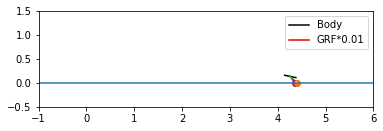

In [18]:
#animate it
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as ani
from IPython.display import HTML
%matplotlib inline

fig1, ax1 = plt.subplots(1,1) #create axes
ax1.set_aspect('equal')

# arrays to store values
N_time = []

def plot_robot(i,m,ax): #update function for animation
    ax.clear()
    ax.set_xlim([x_low_lim,x_high_lim])
    ax.set_ylim([y_low_lim,y_high_lim])
    N_time.append(i)
     
    plot_body = {}
    plot_UL = {}
    plot_UR = {}
    plot_footL = {}
    plot_footR = {}
    abs_angles = {}
    
    # plot boom
    #ax.plot(m.boom_position[i,'X'].value, m.boom_position[i,'Y'].value, marker="o", markersize=5, markeredgecolor="blue", markerfacecolor="black")

    # plot body
    plot_body.update({('x_back'):m.q[i,'x_body'].value - 0.5*m.lengths['body']*cos(m.q[i,'theta_body'].value)})
    plot_body.update({('y_back'):m.q[i,'y_body'].value - 0.5*m.lengths['body']*sin(m.q[i,'theta_body'].value)})
    plot_body.update({('x_front'):m.q[i,'x_body'].value + 0.5*m.lengths['body']*cos(m.q[i,'theta_body'].value)})
    plot_body.update({('y_front'):m.q[i,'y_body'].value + 0.5*m.lengths['body']*sin(m.q[i,'theta_body'].value)})  
    ax.plot([plot_body['x_back'],plot_body['x_front']],[plot_body['y_back'],plot_body['y_front']],color='xkcd:black')

    link_colour = ['red','pink','purple','green','yellow','orange']
    
    #plot upper left
    abs_angles.update({('UL'): m.q[i,'theta_body'].value + m.q[i,'theta_UL'].value})
    plot_UL.update({('top','X'): m.q[i,'x_body'].value})
    plot_UL.update({('top','Y'): m.q[i,'y_body'].value})
    plot_UL.update({('bot','X'): m.q[i,'x_body'].value + m.lengths['UL']*sin(abs_angles['UL'])})
    plot_UL.update({('bot','Y'): m.q[i,'y_body'].value - m.lengths['UL']*cos(abs_angles['UL'])})
    ax.plot([plot_UL['top','X'],plot_UL['bot','X']],[plot_UL['top','Y'],plot_UL['bot','Y']],color='xkcd:{0}'.format(link_colour[0]))


    #plot upper right
    abs_angles.update({('UR'): m.q[i,'theta_body'].value + m.q[i,'theta_UR'].value})
    plot_UR.update({('top','X'): m.q[i,'x_body'].value})
    plot_UR.update({('top','Y'): m.q[i,'y_body'].value})
    plot_UR.update({('bot','X'): m.q[i,'x_body'].value + m.lengths['UR']*sin(abs_angles['UR'])})
    plot_UR.update({('bot','Y'): m.q[i,'y_body'].value - m.lengths['UR']*cos(abs_angles['UR'])})
    ax.plot([plot_UR['top','X'],plot_UR['bot','X']],[plot_UR['top','Y'],plot_UR['bot','Y']],color='xkcd:{0}'.format(link_colour[3]))
    
    #plot left foot
    plot_footL.update({('bot','X'): m.q[i,'x_body'].value + (m.lengths['UL']+m.q[i,'{r_prismatic}_{footL}'].value)*sin(abs_angles['UL'])})
    plot_footL.update({('bot','Y'): m.q[i,'y_body'].value - (m.lengths['UL']+m.q[i,'{r_prismatic}_{footL}'].value)*cos(abs_angles['UL'])})
    ax.plot(plot_footL['bot','X'],plot_footL['bot','Y'],color='xkcd:{0}'.format(link_colour[2]), marker='o')

    #plot right foot
    plot_footR.update({('bot','X'): m.q[i,'x_body'].value + (m.lengths['UR']+m.q[i,'{r_prismatic}_{footR}'].value)*sin(abs_angles['UR'])})
    plot_footR.update({('bot','Y'): m.q[i,'y_body'].value - (m.lengths['UR']+m.q[i,'{r_prismatic}_{footR}'].value)*cos(abs_angles['UR'])})
    ax.plot(plot_footR['bot','X'],plot_footR['bot','Y'],color='xkcd:{0}'.format(link_colour[5]), marker='o')
    
    # virtual prismatic links
    ax.plot([plot_UL['bot','X'],plot_footL['bot','X']],[plot_UL['bot','Y'],plot_footL['bot','Y']],color='xkcd:{0}'.format(link_colour[1]),ls='--')
    ax.plot([plot_UR['bot','X'],plot_footR['bot','X']],[plot_UR['bot','Y'],plot_footR['bot','Y']],color='xkcd:{0}'.format(link_colour[4]),ls='--')
    
    ax.plot([-10,10],[0,0]) # plot the ground
    
    if m.GRF_y[i,'footR'].value > 0.0:
        print('GRF_footR = ',m.GRF_y[i,'footR'].value)
        ax.arrow(plot_footR['bot','X'], plot_footR['bot','Y'], 0, 0.01*m.GRF_y[i,'footR'].value,color='xkcd:{0}'.format('red'),head_width = 0.1)
        
    if m.GRF_y[i,'footL'].value > 0.0:
        print('GRF_footL = ',m.GRF_y[i,'footL'].value)
        ax.arrow(plot_footL['bot','X'], plot_footL['bot','Y'], 0, 0.01*m.GRF_y[i,'footL'].value,color='xkcd:{0}'.format('red'),head_width = 0.1)
    
    ax.legend(["Body","GRF*0.01"], frameon=True)
    
update = lambda i: plot_robot(i,m,ax1) # lambdify update function

animate = ani.FuncAnimation(fig1,update,range(1,N+1),interval = 100,repeat=True)

HTML(animate.to_html5_video()) #you need to convert the animation to HTML5 to embed it in the notebook


In [19]:
f = r"{0}.mp4".format(test) 
writervideo = ani.FFMpegWriter(fps=20) 
animate.save(f, writer=writervideo) 
len(N_time)

GRF_footR =  1.5367885787850875e-09
GRF_footL =  1.0815102040435374e-09
GRF_footR =  1.5367885787850875e-09
GRF_footL =  1.0815102040435374e-09
GRF_footR =  8.306199730318148e-10
GRF_footL =  7.687990575001803e-10
GRF_footR =  6.886509890153003e-10
GRF_footL =  1.0653847601118098e-09
GRF_footR =  8.744476938652681e-10
GRF_footL =  1.1982927595808584e-09
GRF_footR =  1.4660881310915182e-09
GRF_footL =  1.0202483186237078e-09
GRF_footR =  2.4896803454136613e-09
GRF_footL =  1.019674504077781e-10
GRF_footR =  25.18455343495352
GRF_footL =  6.99183779774217e-11
GRF_footR =  2.3464239815756804e-07
GRF_footL =  1.3752805763740809e-10
GRF_footR =  390.80988810129816
GRF_footR =  81.80171923024146
GRF_footR =  67.3408666988631
GRF_footR =  36.56602192010226
GRF_footR =  1.0474907935097348e-07
GRF_footR =  1.497415907147837e-08
GRF_footR =  1.1906270884811102e-08
GRF_footR =  3.859551752126905e-09
GRF_footR =  2.229014371896342e-09
GRF_footR =  1.590153801177944e-09
GRF_footR =  7.7851004844296

202

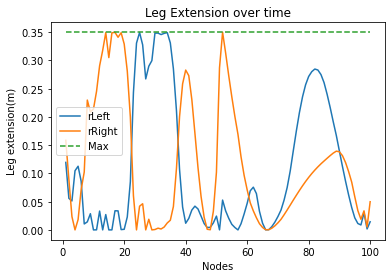

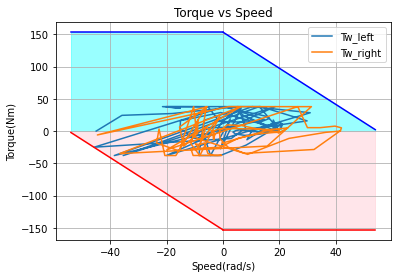

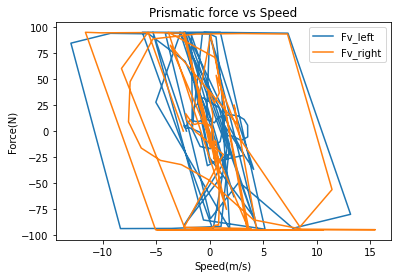

In [20]:
vel = 0.0

nodes = []
max_extension = []


xbody = []
ybody = []
thbody = []
thUL = []
thUR = []
rLeft = []
rRight = []

dxbody = []
dybody = []
dthbody = []
dthUL = []
dthUR = []
drLeft = []
drRight = []

ddxbody = []
ddybody = []
ddthbody = []
ddthUL = []
ddthUR = []
ddrLeft = []
ddrRight = []

Torque_left = []
Torque_right = []

Prismatic_Force_left = []
Prismatic_Force_right = []


GRF_y_left = []
GRF_y_right = []

angular_speed_left = []
angular_speed_right = []

Fp_speed_left = []
Fp_speed_right = []

for n in range(1,N+1):
    
    xbody.append(m.q[n,'x_body'].value)
    ybody.append(m.q[n,'y_body'].value)
    thbody.append(m.q[n,'theta_body'].value)
    thUL.append(m.q[n,'theta_UL'].value)
    thUR.append(m.q[n,'theta_UR'].value)
    rLeft.append(m.q[n,'{r_prismatic}_{footL}'].value)
    rRight.append(m.q[n,'{r_prismatic}_{footR}'].value)

    dxbody.append(m.dq[n,'x_body'].value)
    dybody.append(m.dq[n,'y_body'].value)
    dthbody.append(m.dq[n,'theta_body'].value)
    dthUL.append(m.dq[n,'theta_UL'].value)
    dthUR.append(m.dq[n,'theta_UR'].value)
    drLeft.append(m.dq[n,'{r_prismatic}_{footL}'].value)
    drRight.append(m.dq[n,'{r_prismatic}_{footR}'].value)

    ddxbody.append(m.ddq[n,'x_body'].value)
    ddybody.append(m.ddq[n,'y_body'].value)
    ddthbody.append(m.ddq[n,'theta_body'].value)
    ddthUL.append(m.ddq[n,'theta_UL'].value)
    ddthUR.append(m.ddq[n,'theta_UR'].value)
    ddrLeft.append(m.ddq[n,'{r_prismatic}_{footL}'].value)
    ddrRight.append(m.ddq[n,'{r_prismatic}_{footR}'].value)

    Torque_left.append(m.tau_torque[n,'left'].value)
    Torque_right.append(m.tau_torque[n,'right'].value)

    Prismatic_Force_left.append(m.Fp[n,'left'].value)
    Prismatic_Force_right.append(m.Fp[n,'right'].value)
    
    nodes.append(n)
    max_extension.append(0.35)
    
    GRF_y_left.append(m.GRF_y[n,'footL'].value)
    GRF_y_right.append(m.GRF_y[n,'footR'].value)

    angular_speed_left.append(m.tau_velocity[n,'left'].value)
    angular_speed_right.append(m.tau_velocity[n,'right'].value)

    Fp_speed_left.append(m.Fp_velocity[n,'left'].value)
    Fp_speed_right.append(m.Fp_velocity[n,'right'].value)
    
    #print(m.q[n,'y_body'].value)
    #print(m.q[n,'{r_prismatic}_{footL}'].value)
    #print(m.foot_position[n, 'Y', 'footR'].value)
    #print(m.q[n,'y_body'].value)
    #print(m.dq[n,'x_body'].value)
    #vel = vel + m.dq[n,'x_body'].value
    #print(m.GRF_y[n,'footL'].value)
    #print(m.tau_torque[n,'left'].value)
    pass



''' Store first values in csv file '''
import csv
if test == 'Periodic_Run':
    csv_file_name = str(int(V_avg))
    
    heading1 = ['x_body','y_body','theta_body','theta_UL','theta_UR','r_left','r_right']
    data1 = [xbody[0],ybody[0],thbody[0],thUL[0],thUR[0],rLeft[0],rRight[0]]
    heading2 = ['dx_body','dy_body','dtheta_body','dtheta_UL','dtheta_UR','dr_left','dr_right']
    data2 = [dxbody[0],dybody[0],dthbody[0],dthUL[0],dthUR[0],drLeft[0],drRight[0]]
    heading3 = ['ddx_body','ddy_body','ddtheta_body','ddtheta_UL','ddtheta_UR','ddr_left','ddr_right']
    data3 = [ddxbody[0],ddybody[0],ddthbody[0],ddthUL[0],ddthUR[0],ddrLeft[0],ddrRight[0]]
    
    heading = heading1 + heading2 + heading3
    data = data1 + data2 + data3
    
    with open(csv_file_name+'.csv', 'w') as f:
        writer = csv.writer(f)
        
        for item in range(len(heading)):
            tmp = [heading[item],data[item]]
            writer.writerow(tmp)

plt.figure()
plt.plot(nodes,rLeft)
plt.plot(nodes,rRight)
plt.plot(nodes,max_extension,linestyle = '--')
plt.title("Leg Extension over time")
plt.ylabel("Leg extension(m)")
plt.xlabel("Nodes")
plt.legend(["rLeft", "rRight","Max"], loc=0, frameon=True)

plt.figure()
plt.plot(angular_speed_left,Torque_left)
plt.plot(angular_speed_right,Torque_right)
plt.grid()
plt.plot(x_p, y_p,'b')
plt.plot(x_n, max_torque_p,'b')

plt.fill_between(x_p, y_p, alpha=0.4, color = 'cyan')
plt.fill_between(x_n, max_torque_p, alpha=0.4,color = 'cyan')

plt.plot(x_n, y_n,'r')
plt.plot(x_p, max_torque_n,'r')

plt.fill_between(x_n, y_n, alpha=0.4,color = 'pink')
plt.fill_between(x_p, max_torque_n, alpha=0.4,color = 'pink')

plt.title("Torque vs Speed")
plt.ylabel("Torque(Nm)")
plt.xlabel("Speed(rad/s)")
plt.legend(["Tw_left", "Tw_right"], loc=0, frameon=True)

plt.figure()
plt.plot(Fp_speed_left,Prismatic_Force_left)
plt.plot(Fp_speed_right,Prismatic_Force_right)
plt.title("Prismatic force vs Speed")
plt.ylabel("Force(N)")
plt.xlabel("Speed(m/s)")
plt.legend(["Fv_left", "Fv_right"], loc=0, frameon=True)

In [21]:
print(results.solver.termination_condition) # check if optimal

optimal


<a href='#initial_conditions'>Link to initial conditions'</a>

<a href='#time_step'>Link to time step (select motion)'</a>

<a href='#cost_function'>Link to cost function'</a>

<a href='#constraints'>Link to constraints'</a>

In [22]:
rLeft[0]

0.11955543884840995